# Table of Contents

    1. Setting Up Our Working Environment
    2. Initial Inspection and Data Exploration
        2.1 Inital Inspection
        2.2 Visualizing the Target Variable
    3. Explanatory Data Analysis
        3.1 Sorting the Data for EDA
        3.2 Visualization for Explanatory Data Analysis
    4. Preprocessing
        4.1 Cleaner Class
        4.2 Suggestions from the DataCleaner
        4.3 Feature Engineering
        4.4 Preprocessing Categorical and Numerical Variables
            4.4.1 Preprocessing Categorical Variables
                4.4.1.1. One Hot-Encoding for OLS
                4.4.1.2  One Hot-Encoding for the Machine Learning Models (NLP Included)
            4.4.2 Preprocessing Numeric Variables
    5. Benchmark Models
        5.1 Set Up
        5.2 OLS
        5.3 Random Forest
        5.4 Gradient Boosting
        5.5 Feed Forward Neural Network
    6. NLPs
        6.1 EDA for the Textual Data
        6.2 Functions for Preprocessing
        6.3 Apply 'preprocess_text'
        6.4 Model with No Pre-Trained Embeddings
        6.5 Preprocessing with GLOVE
        6.6 Models Using Pre-Trained Embeddings
    7. Final Models
        7.1 Final Transformer
        7.2 Final BiGRU
    8. Conclusion
    Sources

The main objective of this assignment is to predict the rental price per night for Airbnb listings in London. To accomplish this, we will us a dataset comprising over 55,000 property listings. The dataset includes numerous numerical and categorical variables and, importantly, textual descriptions of the listings. For our predictions we will use numerous modelling techniques and especially Natural Language Processing (NLP) techniques.

The notebook contains some steps that in the end turned out to be redundant, e.g. chapter 4.4.1.1. They have been retained to demonstrate the logical structure of the work process. Due to limited computational power on our own computer, the models were trained in Google Colab. **Since we were unsure in which enviroment this notebook will be evaluated, we included a code cell to upload the data in Colab and to upload the data into Jupyter Notebook. The evaluator only has to remove the number signs (#) and define the file paths to upload the code either way.** The same method applies if the evaluator wants to download the results of the final models.

The structure of this notebook is the following. After setting up our working enviroment, we get a first overview of the data. This look at the data is deepened in the third chapter, Explanatory Data Analysis (EDA). We then preprocess our numerical and categorical data and use it in our benchmark models. Before we can use NLP techniques, we first evaluate our textual data via EDA and then preprocess it. After building various NLP models, we build our two final models in which we combine the numerical, the categorical and the textual data.

# 1. Setting Up Our Working Environment
We start of by importing necessary libraries, downloading NLTK resources and loading the data into DataFrames for both training and testing datasets.

In [1]:
import io
import re
import string
import pandas as pd
import numpy as np
import os
import requests
import zipfile

import collections
from collections import Counter

import gensim
from gensim.models import Word2Vec

import scipy
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from IPython.display import display

import datetime
from datetime import datetime

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**If using Colab**

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_test = "/content/drive/MyDrive/ADAMS/test.csv"
path_train = "/content/drive/MyDrive/ADAMS/train.csv"

df_test = pd.read_csv(path_test)
df_train = pd.read_csv(path_train)
df_raw_test = df_test.copy()

**If using Jupyter Notebook**

In [ ]:
#Set file paths
#url_train = "C:/Users/soere/OneDrive/Desktop/Masterstudium/ADAMS/Final Assignment/train.csv"
#url_test = "C:/Users/soere/OneDrive/Desktop/Masterstudium/ADAMS/Final Assignment/test.csv"

#Import the training data
#df_train = pd.read_csv(url_train)

#Import the test data
#df_test = pd.read_csv(url_test)
#df_raw_test = df_test.copy()

# 2. Initial Inspection and Data Exploration
Before delving into Explanatory Data Analysis (EDA) and data preprocessing, an initial overview of the data is valuable. Presented below are the initial rows of the training and test DataFrames (df_train and df_test), allowing us to examine their content and structure.

## 2.1 Inital Inspection

In [6]:
pd.set_option("display.max_columns", None)
df_train.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,2012-04-18,within an hour,100%,t,1.0,t,f,Greenwich,Greenwich,SE10 8SX,51.47457,-0.01062,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Wifi,""Paid parking off premises"",Heating,Wash...",35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,2014-05-29,within a few hours,100%,t,1.0,t,t,LB of Haringey,Haringey,N8 8NR,51.58329,-0.12416,Guesthouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Breakfast,...",75.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,2019-06-28,within an hour,100%,f,2.0,t,f,LB of Merton,Merton,SW19 1DG,51.41634,-0.18567,Apartment,Entire home/apt,5,1.0,1.0,2.0,Real Bed,"{Wifi,Kitchen,""Paid parking off premises"",Heat...",120.0,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,2012-08-24,within a few hours,100%,f,1.0,t,f,Clapham,Lambeth,SW4 9EF,51.45622,-0.14137,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,""Smoke detecto...",50.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,2016-09-09,within an hour,100%,t,2.0,t,f,LB of Lambeth,Lambeth,SE11 5TL,51.48114,-0.11219,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",H...",104.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


In [7]:
df_test.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Ladbroke Grove Stylish Portobello Apartment,"Large, bright and contemporary flat located in...",NaN,"Large, bright and contemporary flat located in...",none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/9e15bc56-a...,28086957,2015-02-21,NaN,NaN,f,1.0,t,t,RB of Kensington and Chelsea,Kensington and Chelsea,W10 6HJ,51.51837,-0.21065,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,W...",1,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.89,0FEMC4VA5U
1,Contemporary Design in Notting Hill,Stylish design on a beautiful tree lined stree...,The (Phone number hidden by Airbnb) ) is thoug...,Stylish design on a beautiful tree lined stree...,none,"Notting Hill is a trendy, artistic, bohemian n...",There are 2 underground stations within walkin...,NaN,https://a0.muscache.com/im/pictures/c2ea8799-e...,16965290,2014-06-18,within an hour,100%,t,14.0,t,f,Westbourne Green,Westminster,W2 5DH,51.51734,-0.19712,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,Dryer,""Smoke d...",1,97.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,2.50,PQ2BYEO0QR
2,En-suite double bedroom,Quiet en-suite double bedroom in our lovely ho...,NaN,Quiet en-suite double bedroom in our lovely ho...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/4b86abd0-0...,4363076,2012-12-09,NaN,NaN,f,1.0,t,t,LB of Camden,Camden,NW1 8DU,51.54288,-0.14720,House,Private room,2,2.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,3FP6WFHUBN
3,Double room with balcony in magnificent penthouse,My place is close to Aldgate . You’ll love my ...,NaN,My place is close to Aldgate . You’ll love my ...,none,NaN,NaN,"- No parties, events or guests",https://a0.muscache.com/im/pictures/23ea2939-6...,7603738,2013-07-20,NaN,NaN,f,1.0,t,t,LB of Tower Hamlets,Tower Hamlets,E1,51.51159,-0.06358,Apartment,Private room,1,1.5,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Dryer,""S...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,GG0V2KDG90
4,The Bockery Suite 2 Chelsea,This 26m2 Suite comprises of 1 bedroom and 1 b...,"Whether it's just for you or your family, whet...",This 26m2 Suite comprises of 1 bedroom and 1 b...,none,When you have had your fill of relaxing in the...,Our visitors often tell us that they had no id...,What you do in the privacy of your own room is...,https://a0.muscache.com/im/pictures/64910777/2...,26586101,2015-01-23,a few days or more,0%,f,3.0,t,t,Chelsea,Kensington and Chelsea,SW10 0TB,51.48379,-0.18498,Boutique hotel,Private room,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Pets allowed"",""Pets live on this pro...",2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,0.95,TZVVK4YSIO


**Listing ID**

The listing_id can be used as an identifier for every single observation. Thus it can be used to check if there is an overlap between the train and test dataset. It can also be used to check if some obeservations are double counted. The results are that there is no overlap between the train and test data and that there seems to be no duplicates in both datasets.

In [8]:
#Find common listing_id values between df_train and df_test
common_ids = set(df_train["listing_id"]).intersection(set(df_test["listing_id"]))

#Calculate the absolute number of matches
absolute_matches = len(common_ids)

#Calculate the relative number of matches
relative_matches = absolute_matches / df_test["listing_id"].nunique()

#See if there is some double counting
double_id_train = 100-((df_train["listing_id"].nunique()/len(df_train["listing_id"]))*100)
double_id_test = 100- ((df_test["listing_id"].nunique()/len(df_test["listing_id"]))*100)

#Output the results
print("Absolute Matches:", absolute_matches)
print("Relative Matches:", relative_matches)
print("The training data has", double_id_train, "% doubeling values")
print("The testing data has", double_id_train, "% doubeling values")

Absolute Matches: 0
Relative Matches: 0.0
The training data has 0.0 % doubeling values
The testing data has 0.0 % doubeling values


**Drop columns**

Since it contains no valuable information, as shown above, we drop the column 'listing_id' from both datasets. We also drop further columns. 'picture_url' is dropped since we don't plan on using it for the prediction task. 'neighbourhood' is dropped, due to the existence of 'neighbourhood_cleansed' and 'zipcode' is dropped since the same informational value should also be contained in a combination of the columns 'neighbourhood_cleansed', 'latitude' and 'longitude'.

In [9]:
#Drop the listing_id due to no overlap
df_train = df_train.drop("listing_id", axis=1)
df_test = df_test.drop("listing_id", axis=1)

#Drop picture_url
df_train = df_train.drop("picture_url", axis=1)
df_test = df_test.drop("picture_url", axis=1)

#Drop neighbourhood
df_train = df_train.drop("neighbourhood", axis=1)
df_test = df_test.drop("neighbourhood", axis=1)

#Drop zipcode
df_train = df_train.drop("zipcode", axis=1)
df_test = df_test.drop("zipcode", axis=1)

**Check and drop 'host_id'**

To check if some hosts are part of the train and test datasets, we compare the 'host_id' values between the two DataFrames. This analysis reveals that around 27% of all host ids in the test dataset are can also be found in the train dataset. We contemplated what to do with this information but decided to drop the column, since this maybe would have helped us to build a very good predicitve model by intentionally overfitting for the task at hand. But this would have sacrificied the general use of our model.

In [10]:
#Find common host_id values between df_train and df_test
common_ids = set(df_train["host_id"]).intersection(set(df_test["host_id"]))

#Calculate the absolute number of matches
absolute_matches = len(common_ids)

#Calculate the relative number of matches
relative_matches = absolute_matches / df_test["host_id"].nunique()

#Output the results
print("Absolute Matches:", absolute_matches)
print("Relative Matches:", relative_matches)

Absolute Matches: 6042
Relative Matches: 0.27260422306442883


In [11]:
#Drop host_id
df_overfit_train = df_train
df_overfit_test = df_test
df_train = df_train.drop("host_id", axis=1)
df_test = df_test.drop("host_id", axis=1)

**Defining a function to compare dataset columns and structure**

Using the .head() function complicated the assessment if both datasets contain the same columns and if they are at the same place in the datasets. Thus we design a function for assessment. This function will come in handy later and help with identifying problems, e.g. when we one hot encoded categorical variables. Using this function shows that the only difference is the 'price' variable that is missing in the 'df_test' DataFrame.

In [12]:
def compare_column_names(df1, df2):
    df1_columns = set(df1.columns)
    df2_columns = set(df2.columns)

    output_data = []
    for i, column in enumerate(sorted(df1_columns.union(df2_columns))):
        if column in df1_columns and column in df2_columns:
            index_match = (df1.columns.get_loc(column) == df2.columns.get_loc(column))
            output_data.append([column, "Found", "Found", i, df1.columns.get_loc(column), df2.columns.get_loc(column), "Match" if index_match else "Mismatch"])
        elif column in df1_columns:
            output_data.append([column, "Found", "Not found", i, df1.columns.get_loc(column), "", ""])
        else:
            output_data.append([column, "Not found", "Found", i, "", df2.columns.get_loc(column), ""])

    output_df = pd.DataFrame(output_data, columns=["Column Name", "Dataframe 1", "Dataframe 2", "Index", "Index (DF1)", "Index (DF2)", "Match"])
    return output_df

compare_column_names(df_train, df_test)

,Column Name,Dataframe 1,Dataframe 2,Index,Index (DF1),Index (DF2),Match
0,accommodates,Found,Found,0,20,20,Match
1,amenities,Found,Found,1,25,25,Match
2,bathrooms,Found,Found,2,21,21,Match
3,bed_type,Found,Found,3,24,24,Match
4,bedrooms,Found,Found,4,22,22,Match
5,beds,Found,Found,5,23,23,Match
6,cancellation_policy,Found,Found,6,35,34,Mismatch
7,description,Found,Found,7,3,3,Match
8,experiences_offered,Found,Found,8,4,4,Match
9,guests_included,Found,Found,9,27,26,Mismatch


**Target variable transformation**

We assign the 'price' to the variable y_train. The log-transformation of the target variable is conducted to stabilize variance and reduce noise and the impact of outliers. We also save one original copy of the price.

In [13]:
y_train = df_train["price"]
y_no_log = y_train.copy()
y_train = np.log(y_train)

## 2.2 Visualizing the Target Variable

To get a better overview of a variable, it can be useful to visualize it. A histogram and boxplot of the target variable confirm the rationale behind the log-transformation. Outliers are evident in the original price histogram's right tail, affirmed by boxplots. It is not shown in this notebook, but later when configuring the models, using the log-transformed target variable improved the model performance immensly.

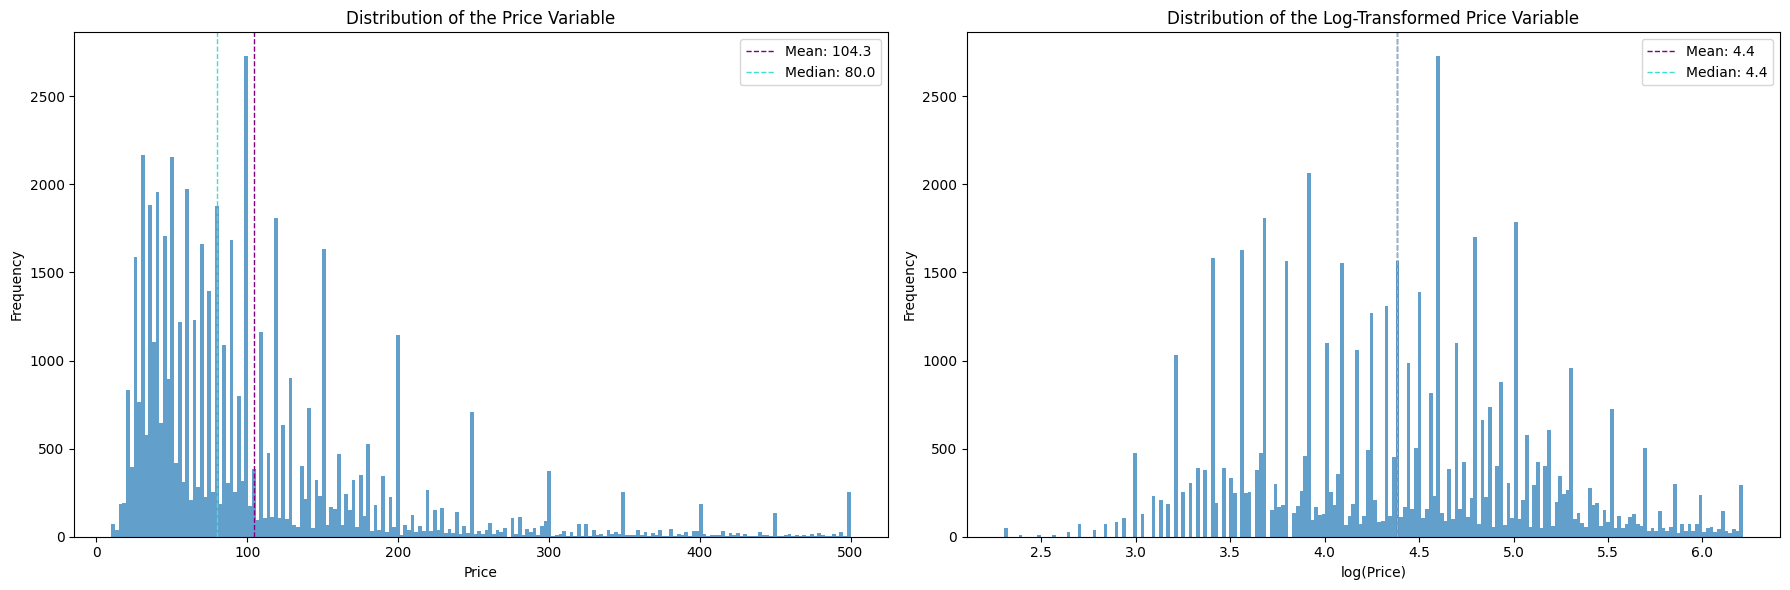

In [16]:
plt.figure(figsize=(18, 6))

#Create the histogram for y_no_log
plt.subplot(1, 2, 1)
plt.hist(y_no_log, bins=200, alpha=0.7)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of the Price Variable")

#Calculate mean and median for y_no_log and plot it
mean_no_log = np.mean(y_no_log)
median_no_log = np.median(y_no_log)

plt.axvline(mean_no_log, color="purple", linestyle="dashed", linewidth=1, label=f"Mean: {mean_no_log:.1f}")
plt.axvline(median_no_log, color="turquoise", linestyle="dashed", linewidth=1, label=f"Median: {median_no_log:.1f}")

plt.legend()

#Create the histogram for log-transformed y_train
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=200, alpha=0.7)
plt.xlabel("log(Price)")
plt.ylabel("Frequency")
plt.title("Distribution of the Log-Transformed Price Variable")

#Calculate mean and median for y_train and plot it
mean_train = np.mean(y_train)
median_train = np.median(y_train)

plt.axvline(mean_train, color="purple", linestyle="dashed", linewidth=1, label=f"Mean: {mean_train:.1f}")
plt.axvline(median_train, color="turquoise", linestyle="dashed", linewidth=1, label=f"Median: {median_train:.1f}")

plt.legend()

plt.tight_layout()
plt.show()


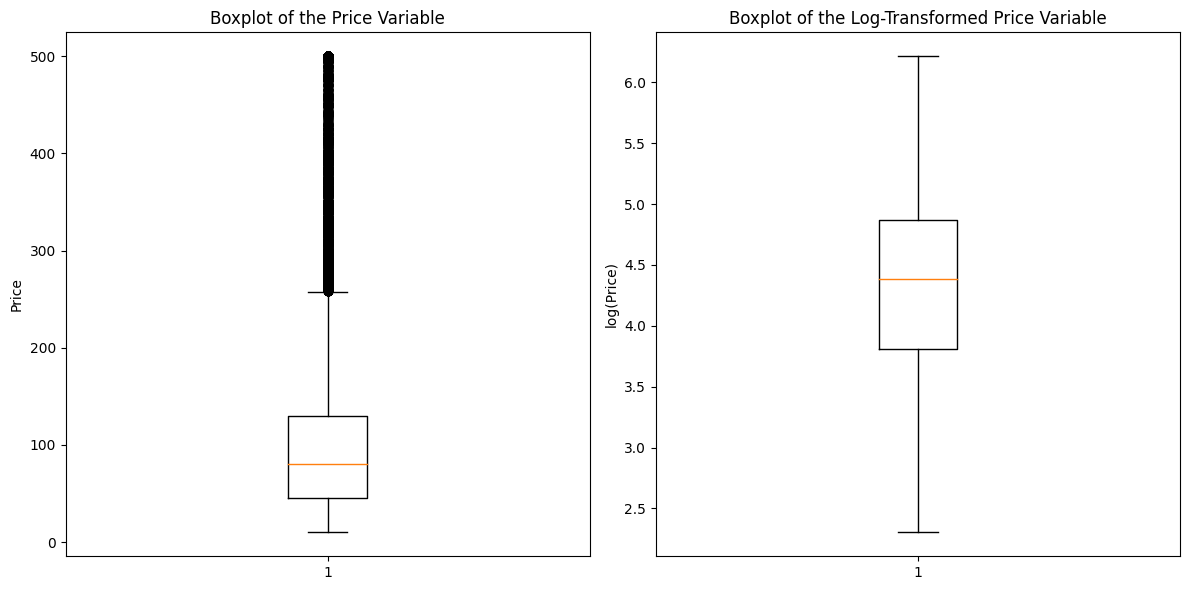

In [15]:
plt.figure(figsize=(12, 6))

#Boxplot for y_no_log
plt.subplot(1, 2, 1)
plt.boxplot(y_no_log)
plt.ylabel("Price")
plt.title("Boxplot of the Price Variable")

#Boxplot for y_train
plt.subplot(1, 2, 2)
plt.boxplot(y_train)
plt.ylabel("log(Price)")
plt.title("Boxplot of the Log-Transformed Price Variable")

plt.tight_layout()
plt.show()

# 3. Explanatory Data Analysis

The data will be sorted into two categories: Numerical and categorical data. The categorical and numerical data are summarized and visualized. The numerical and categorical categories don't contain 'host_since' and 'amenities', since we have to perform feature engineering on them first.

## 3.1 Sorting the Data for EDA

Numerous ways to automatize the sorting process were tried, but in the end manual configuration was always needed. There could be two ways to sort 'amenities' for example. When included as textual data, it actually worsened the predictions of the language models. Thus the decision later to configure it and to try to include it as a categorical variable, which also worsened our results.

In [17]:
categorical_columns = ["experiences_offered",
                       "host_response_time",
                       "host_is_superhost",
                       "host_has_profile_pic",
                       "host_identity_verified",
                       "neighbourhood_cleansed",
                       "property_type",
                       "bed_type",
                       "room_type",
                       "cancellation_policy"]

numerical_columns = ["host_total_listings_count",
                     "latitude",
                     "longitude",
                     "accommodates",
                     "bathrooms",
                     "bedrooms",
                     "beds",
                     "guests_included",
                     "review_scores_rating",
                     "review_scores_accuracy",
                     "review_scores_cleanliness",
                     "review_scores_checkin",
                     "review_scores_communication",
                     "review_scores_location",
                     "review_scores_value",
                     "reviews_per_month"]

In [18]:
train_num = df_train.loc[:, numerical_columns]
test_num = df_test.loc[:, numerical_columns]
train_cat = df_train.loc[:, categorical_columns]
test_cat = df_test.loc[:, categorical_columns]

## 3.2 Visualization for Explanatory Data Analysis
To get an insight into the data we plotted the numerical and categorical variables. The purpose is to get a good grasp of the distribution of the variables (e.g. look for extreme outliers) and to be able to compare the train and test dataset. We design two functions. One for the visualization of the numerical variables and one for the visualization of the categorical variables. For the numerical variables there is also a heatmap to show the correlation.

**Histogram of numerical variables**

In [19]:
def histograms(df1, df2):
    columns = df1.columns
    num_columns = len(columns)

    for col in columns:
        plt.figure(figsize=(12,3))
        gs = plt.GridSpec(1, 3, width_ratios=[2, 2, 1])

        #Plot df1
        plt.subplot(gs[0])
        plt.hist(df1[col], bins=50, alpha=0.5)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {col}")

        #Calculate mean and median and plot it
        mean_df1 = np.mean(df1[col])
        median_df1 = np.median(df1[col].dropna())
        plt.axvline(mean_df1, color="red", linestyle="dashed", linewidth=1, label=f"Mean: {mean_df1:.1f}")
        plt.axvline(median_df1, color="green", linestyle="dashed", linewidth=1, label=f"Median: {median_df1:.1f}")
        plt.legend()

        #Plot df2
        plt.subplot(gs[1])
        plt.hist(df2[col], bins=50, alpha=0.5)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {col}")

        #Calculate mean and median and plot it
        mean_df2 = np.mean(df2[col])
        median_df2 = np.median(df2[col].dropna())
        plt.axvline(mean_df2, color="red", linestyle="dashed", linewidth=1, label=f"Mean: {mean_df2:.1f}")
        plt.axvline(median_df2, color="green", linestyle="dashed", linewidth=1, label=f"Median: {median_df2:.1f}")
        plt.legend()

        #Calculate and plot statistical testing for similarity

        #Calculation Kolmogorov-Smirnov test
        data1 = df1[col].values
        data2 = df2[col].values
        ks_stat, ks_p_value = ks_2samp(data1, data2)
        alpha = 0.05

        #Plot the results
        plt.subplot(gs[2])
        if ks_p_value >= alpha:

            results = f"KS Statistic: {ks_stat:.3f}\nKS p-value: {ks_p_value:.3f}\nThe distributions are \nnot statistically significant different."
            plt.text(0.2, 0.2, results, fontsize=9)
            plt.axis("off")

        if ks_p_value < alpha:

            results = f"KS Statistic: {ks_stat:.3f}\nKS p-value: {ks_p_value:.3f}\nThe distributions are \nstatistically significant different."
            plt.text(0.2, 0.2, results, fontsize=10)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

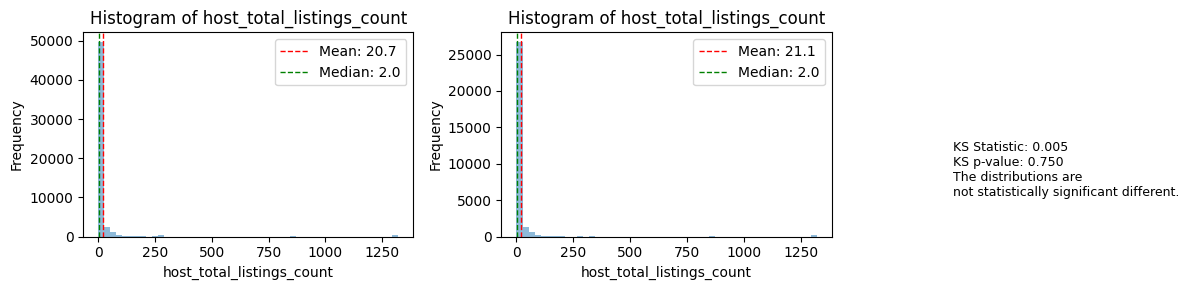

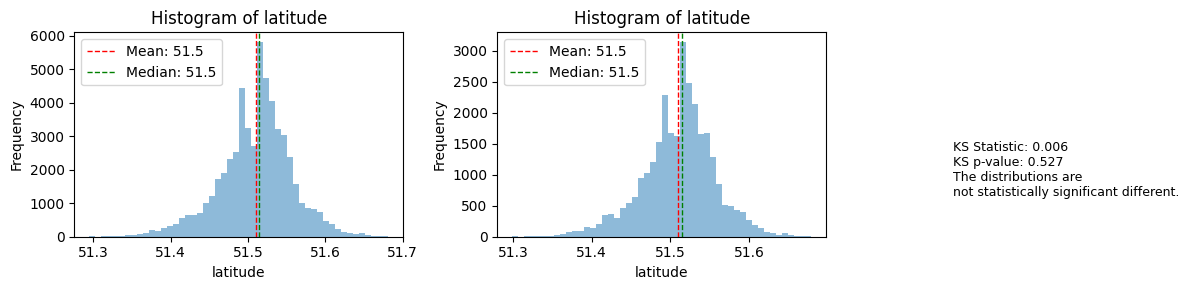

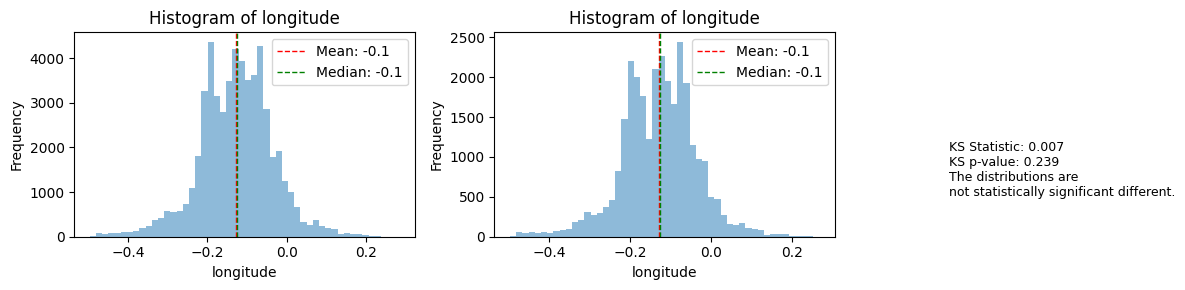

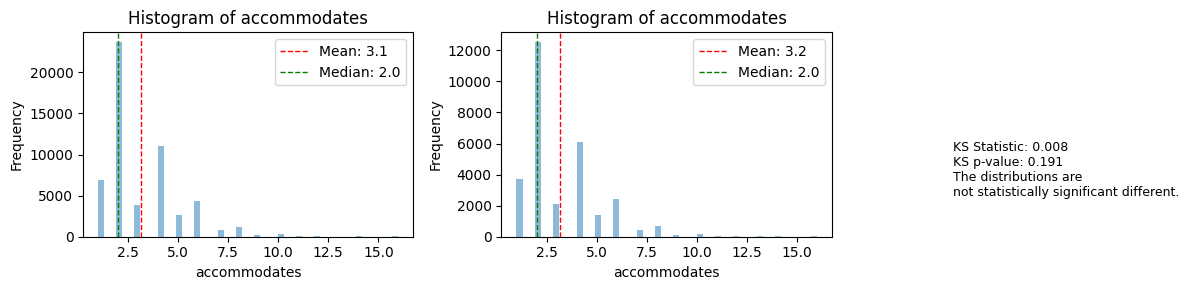

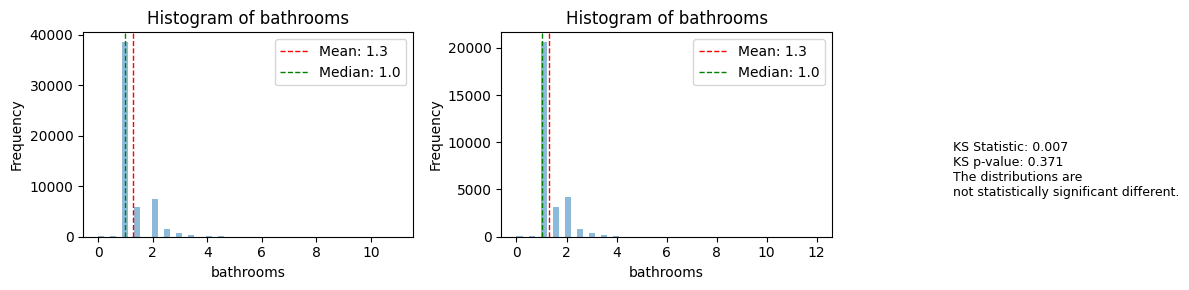

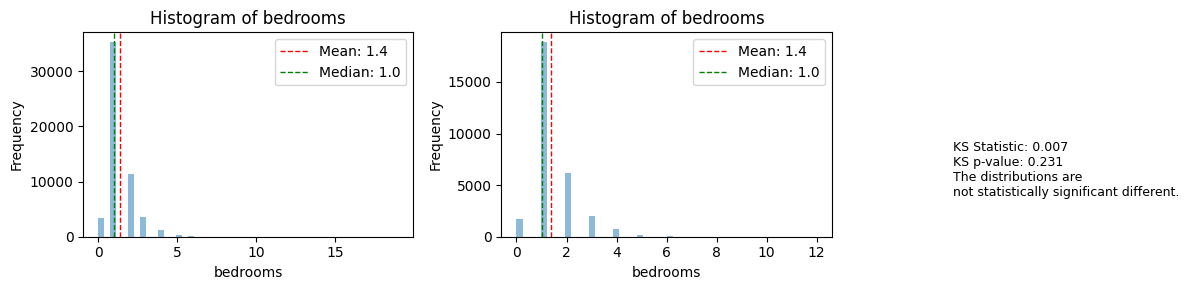

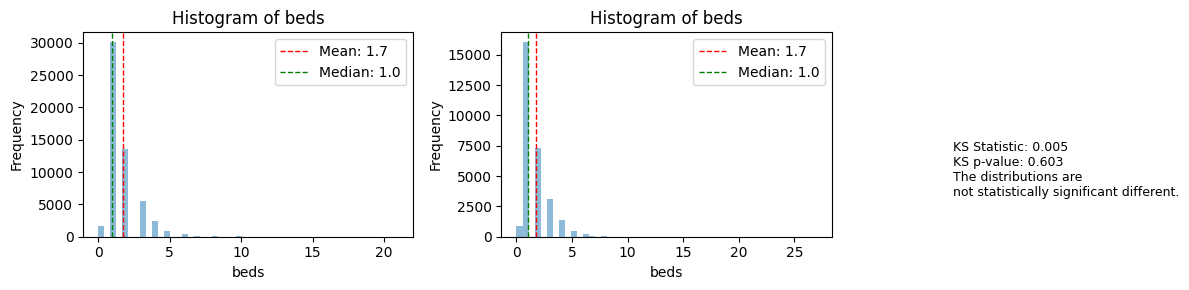

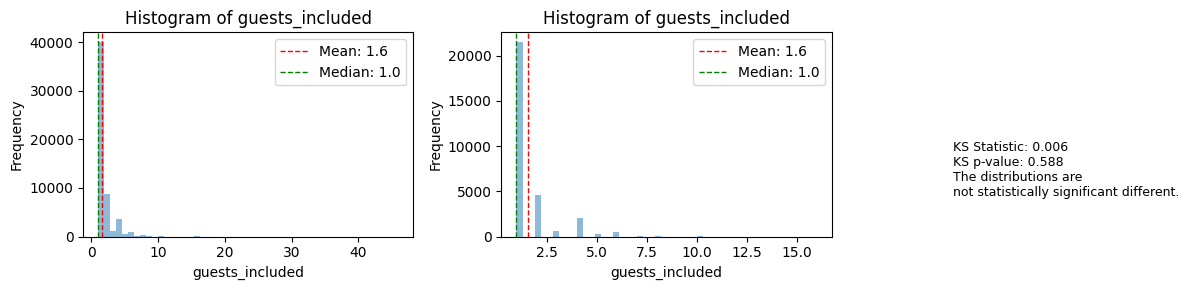

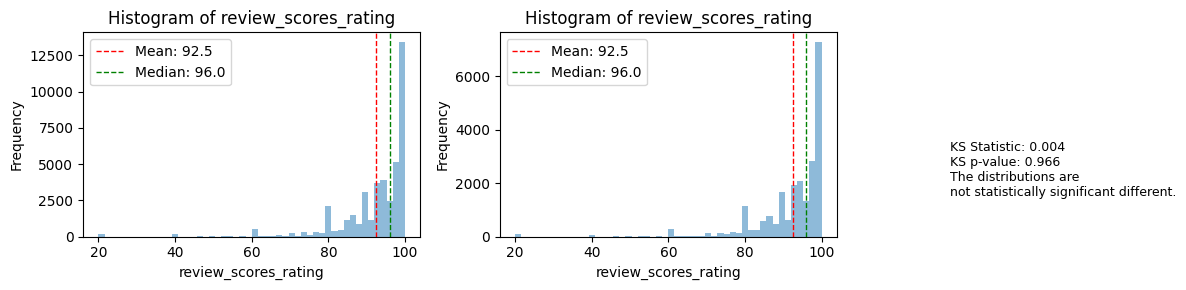

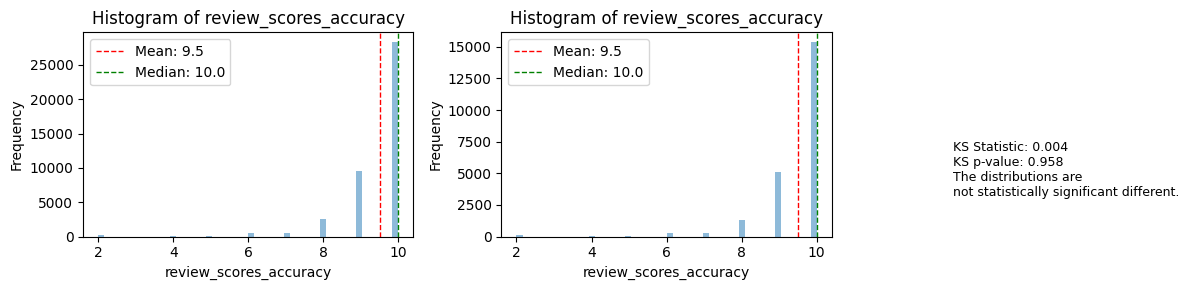

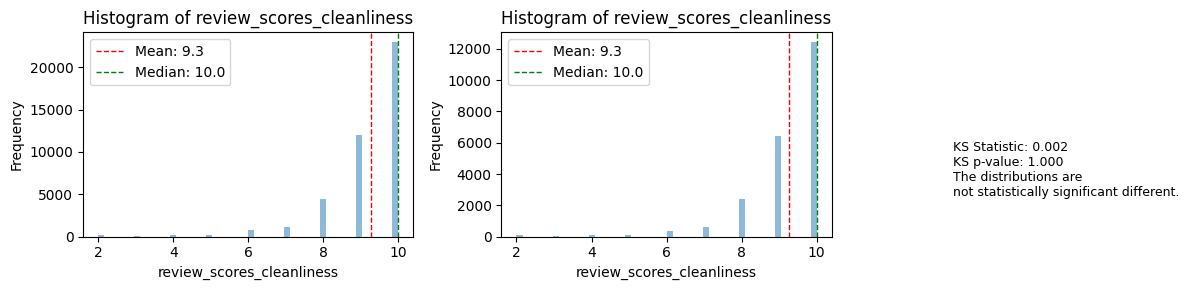

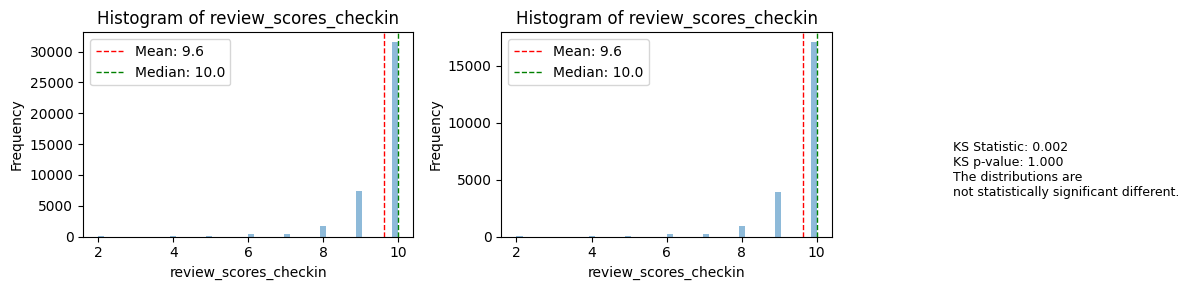

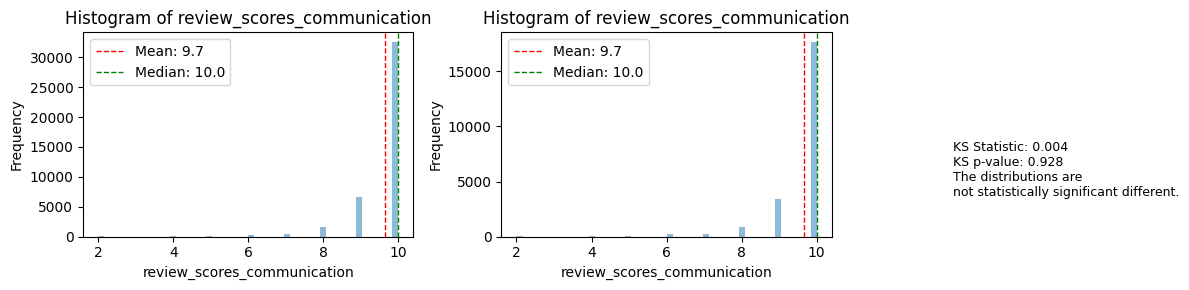

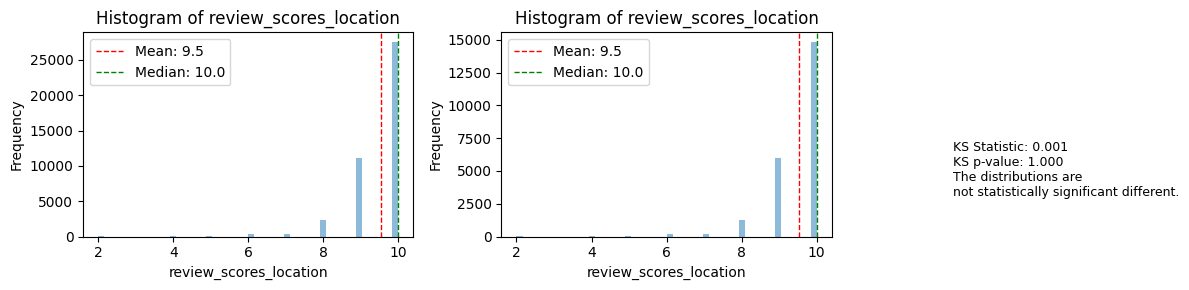

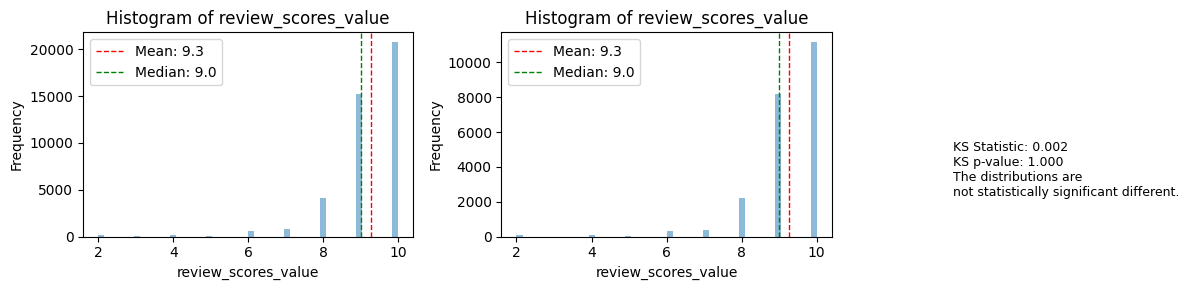

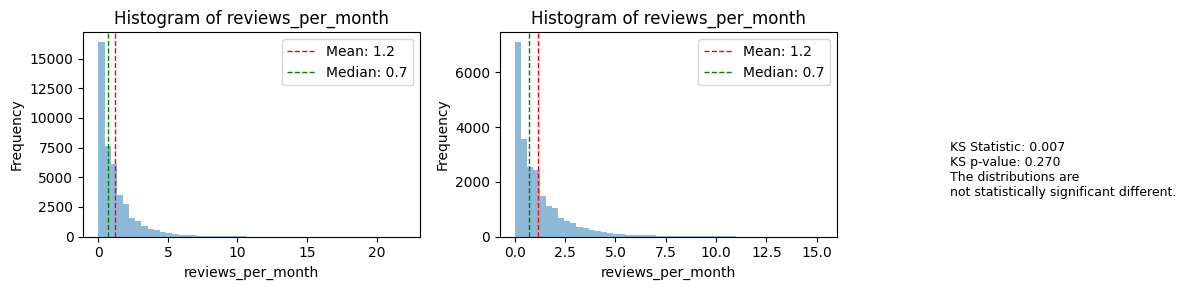

In [20]:
histograms(train_num, test_num)

The outcomes are highly promising. There seems to be no major difference between our test and training data. The distributions, the means and the medians are all similar. We use the [Kolomogorow-Smirnow test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to check if the variables from the test and training data have an identical distribution.
Most numeric feature variables are left- or right-skewed, with z-standardization, we can normalize their distributions later on and make them more suitable for Machine Learning (ML) algorithms.

**Correlation heatmap**

Interesting conclusions can be drawn from the the correlation heatmap below:
- For the numerical variables the variables that define the size of the rented accommodation (e.g. 'beds') seem to have the biggest correlation with the price. Unsuprisingly these variables (e.g. 'beds' and 'bedrooms') also have a high correlation
- Longitude and latitude unsuprinsingly seem to have no linear relationship with the price. For example one intuitivly would think that the city center has the highest prices, with accomodations in all four directions of the compass costing less, the further they are from the center. So this result should not us discourage from finding informational value in the location of one accommodation, it just shows that more sophisticated models than linear ones are needed.
- What is somewhat suprising is the low correlation of all the 'review' variables with the price. There are several possible explanations:
    1. People write the review based on a price-performance ratio, i.e. people that rented for a lower price had lower expectations, and thus the reviews have no explanatory power.
    2. The review variable only has explanatory power in interaction with other feature variables.
    3. There is a bias in the non-response. A supporting argument for this is the left-skew of the 'review' variables depictured in the histograms above.

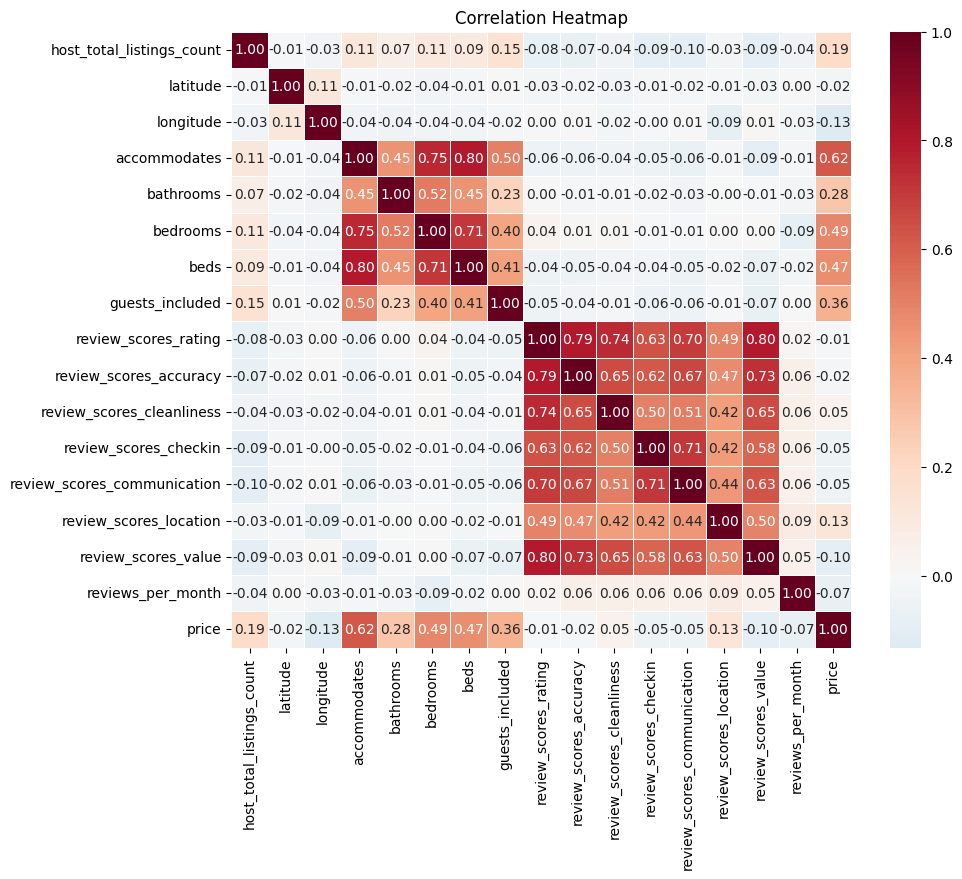

In [21]:
#Concatenate and calculate the correlation
df_heat = pd.concat([train_num, y_train], axis=1)
corr = df_heat.corr()

#Create heatmap
plt.figure(figsize=(10, 8))
ax1 = sns.heatmap(corr, annot=True, fmt=".2f", cbar=True, linewidths=0.5, cmap="RdBu_r", center=0)

plt.title("Correlation Heatmap")
plt.show()

**Compare prices of the reviews with and without missing values to check for a possible bias**

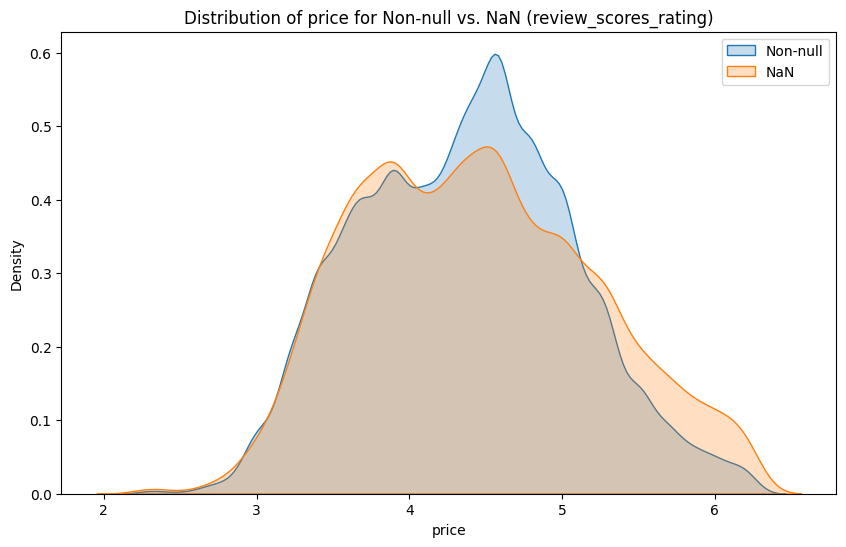

T-test for review_scores_rating - t-statistic: -7.955748362557094, p-value: 1.8714671389725408e-15


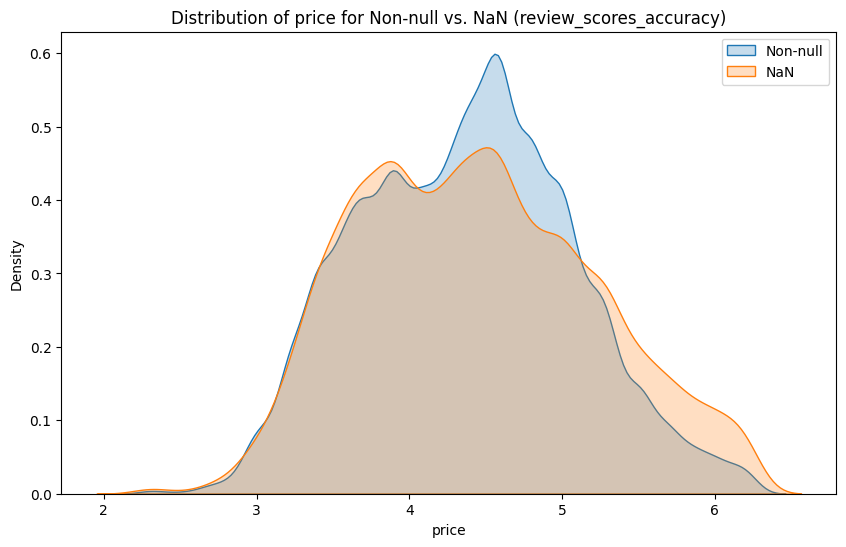

T-test for review_scores_accuracy - t-statistic: -7.865235466062985, p-value: 3.863128419099197e-15


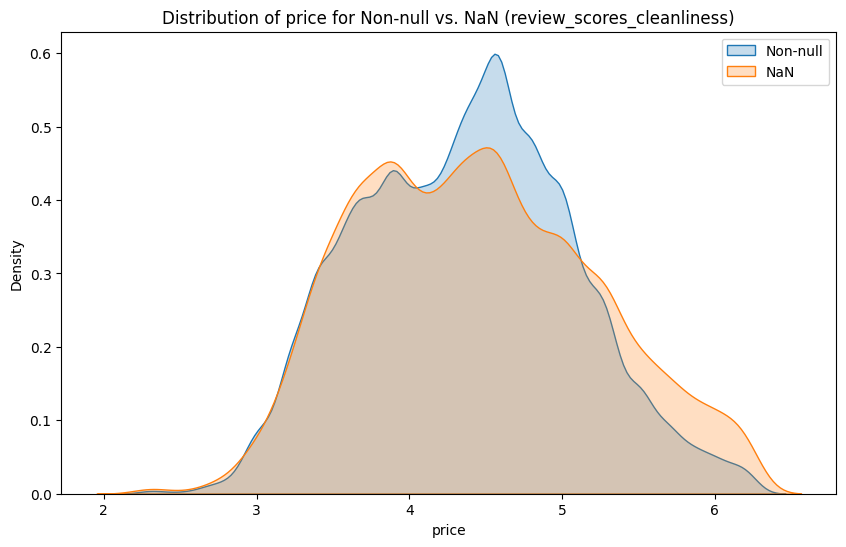

T-test for review_scores_cleanliness - t-statistic: -7.866439729667012, p-value: 3.826396484115957e-15


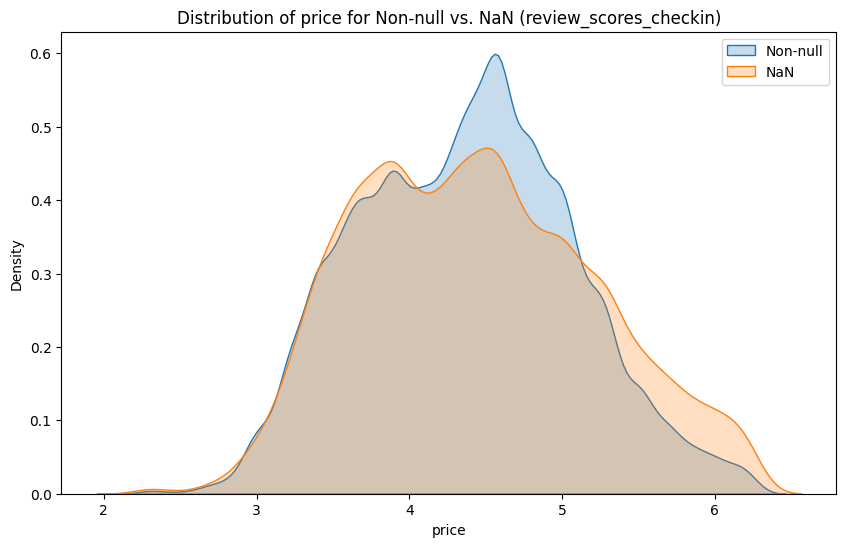

T-test for review_scores_checkin - t-statistic: -7.8618456671036006, p-value: 3.968108663254721e-15


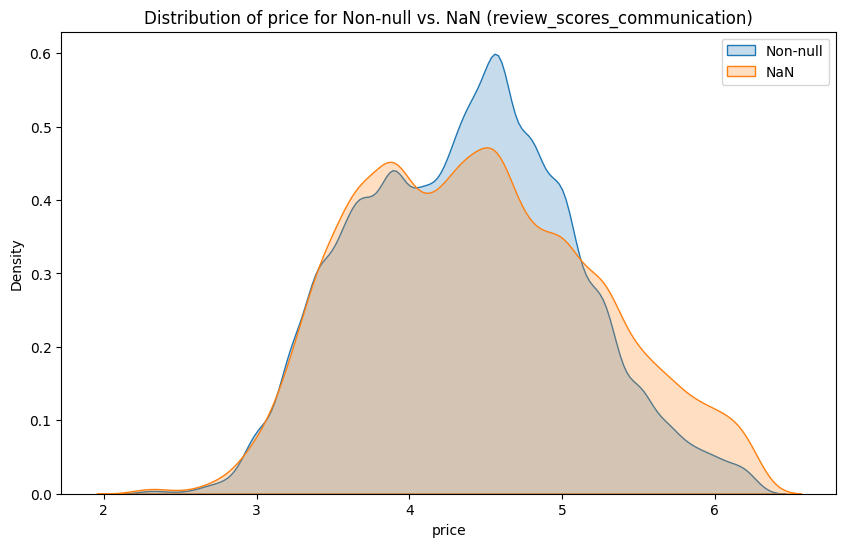

T-test for review_scores_communication - t-statistic: -7.88182351938178, p-value: 3.384610130836103e-15


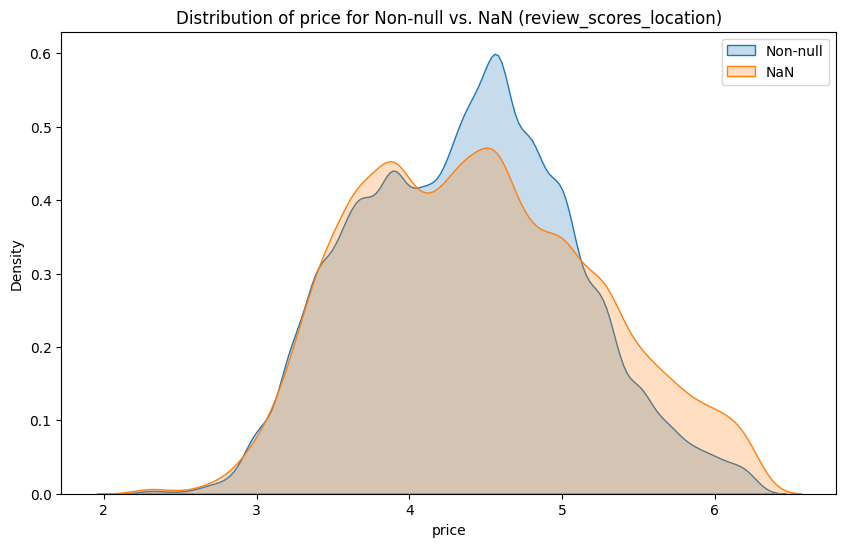

T-test for review_scores_location - t-statistic: -7.894376029836784, p-value: 3.061154469923439e-15


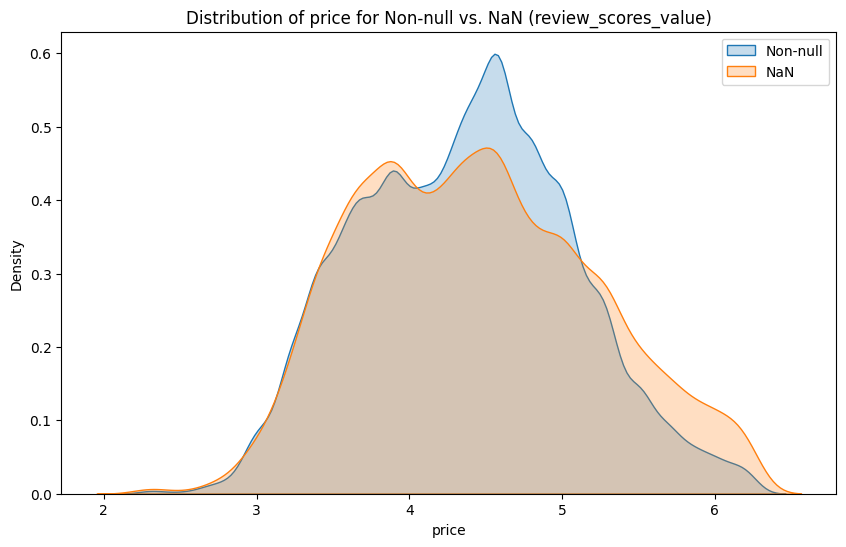

T-test for review_scores_value - t-statistic: -7.906085954638669, p-value: 2.7874373250167695e-15


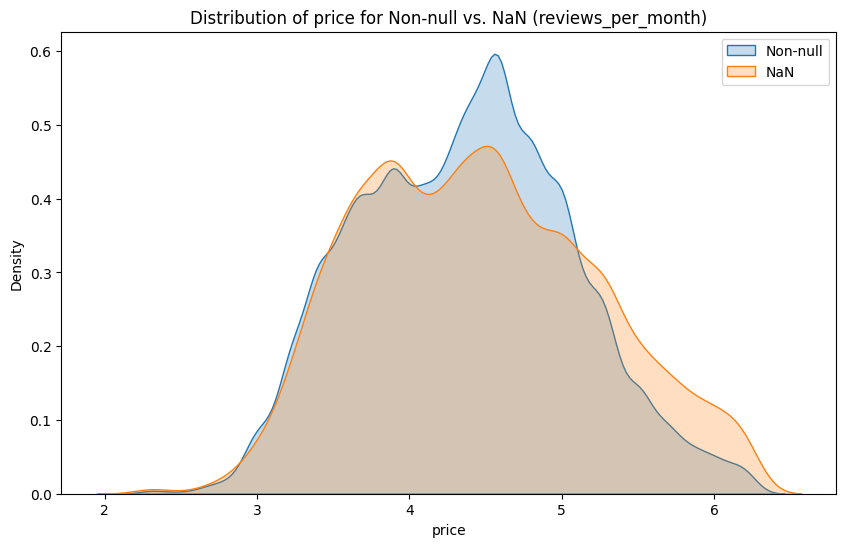

T-test for reviews_per_month - t-statistic: -10.194439957100325, p-value: 2.435955541570512e-24


In [22]:
#Selected columns and target variable
review_columns = ["review_scores_rating",
                  "review_scores_accuracy",
                  "review_scores_cleanliness",
                  "review_scores_checkin",
                  "review_scores_communication",
                  "review_scores_location",
                  "review_scores_value",
                  "reviews_per_month"]

target_column = "price"

for column in review_columns:
    #Split DataFrame into two subsets
    nonnull_subset = df_heat.dropna(subset=[column, target_column])
    nan_subset = df_heat[df_heat[column].isnull()]

    #Compare target variable distribution
    plt.figure(figsize=(10, 6))
    sns.kdeplot(nonnull_subset[target_column], label="Non-null", fill=True)
    sns.kdeplot(nan_subset[target_column], label="NaN", fill=True)
    plt.xlabel(target_column)
    plt.ylabel("Density")
    plt.title(f"Distribution of {target_column} for Non-null vs. NaN ({column})")
    plt.legend()
    plt.show()

    #Perform t-test
    t_statistic, p_value = ttest_ind(nonnull_subset[target_column], nan_subset[target_column], equal_var=False)
    print(f"T-test for {column} - t-statistic: {t_statistic}, p-value: {p_value}")

The p-values indicate that there is a significant difference between the obeservations whom responded and the non-response group. This can be seen as a strong indicator for a non-response bias, with should be taken care of. The plots heuristically confirm that the t-test was the right statistcal method to use, since the price distribution for all of them seems to resemble a normal distribution. We later repeat this test for all variables in the training data.

**Bar chart to compare categorical columns**

In [23]:
def bar_charts(df1, df2, column_names):
    num_columns = len(column_names)
    fig, axes = plt.subplots(num_columns, 2, figsize=(15, 80))

    for i, column in enumerate(column_names):
        if column != "amenities":

            #df1
            counts1 = df1[column].value_counts(dropna=False)
            relative_counts1 = counts1 / len(df1)
            num_categories1 = len(counts1)

            ax1 = axes[i, 0]
            ax1.barh(range(num_categories1), relative_counts1.values)
            ax1.set_yticks(range(num_categories1))
            ax1.set_yticklabels(relative_counts1.index)
            ax1.set_xlabel("Relative Frequency")
            ax1.set_title(f"Frequencies of {column} - df1")

            #df2
            counts2 = df2[column].value_counts(dropna=False)
            relative_counts2 = counts2 / len(df2)
            num_categories2 = len(counts2)

            ax2 = axes[i, 1]
            ax2.barh(range(num_categories2), relative_counts2.values, color='orange')
            ax2.set_yticks(range(num_categories2))
            ax2.set_yticklabels(relative_counts2.index)
            ax2.set_xlabel("Relative Frequency")
            ax2.set_title(f"Frequencies of {column} - df2")

    plt.tight_layout(pad=1)
    plt.show()

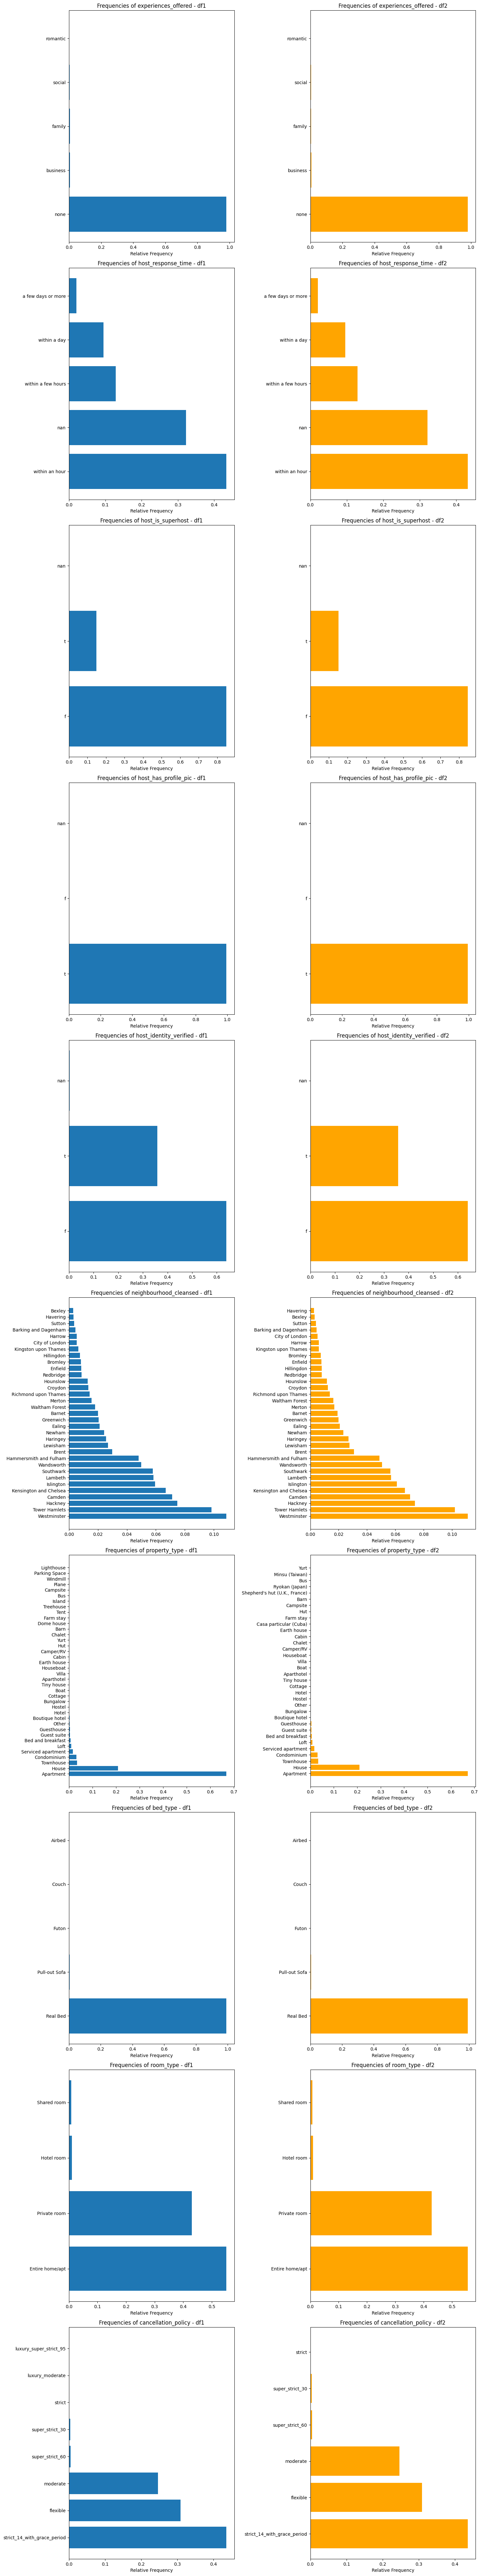

In [24]:
bar_charts(train_cat, test_cat, categorical_columns)

There seems to be no major difference between categorical variables of the test and train dataset. The frequencies are all very similar. In 'neighbourhood_cleansed' some districts switched places between the training and testing data, e.g. Bexley and Havering. This is neglible and will not impede our further analysis and modelling. What stands out is that some categories are part of the training data but not of the testing data and vice versa. For example in the testing data variable 'property_type' one host rents out a 'Shepherds's hut', which can't be found in the training data. This is taken care of and is treated separately during the preparation process later on.

# 4. Preprocessing

The preprocessing can have a strong impact on the predictive power of our models. The structure of the preprocessing is the following:

1. **'DataCleaner'** - We define a class that will help us with the preprocessing.

2. **Suggestions from 'DataCleaner'** - We use the 'DataCleaner' to gain an insight into how we should preprocess our data.

3. **Feature Engineeringe** - We perform feature engineering to transform 'host_since' into a numerical variable and to transform 'amenities' into a categorical variable.

4. **Application of the 'DataCleaner'** - The 'DataCleaner' is being applied to the numerical and categorical data.

## 4.1 Cleaner Class
We set up a class, 'DataCleaner', that helps us with further analyzing and then augmenting the missing values in the the data.

In [99]:
class DataCleaner:

    def Standardizer(self, dataframe, column_names):

        """Function that z-standardizes the numerical values"""

        for column_name in column_names:
            mean = np.mean(dataframe[column_name])
            std = np.std(dataframe[column_name])
            dataframe[column_name] = (dataframe[column_name]-mean)/std

        return dataframe

    def suggestions(self, dataframe, axis, drop=True, threshold=0.5, y=None):

        """Function that helps you to gain an overview over the missing values in your data."""

        if axis == "row":
            self._check_row_missing_values(dataframe, drop, threshold)
        elif axis == "column":
            self._check_column_missing_values(dataframe)
        elif axis == "target" and y:
            self._check_target_variable(dataframe, y)
        elif axis == "target" and y == None:
            print("No value for the target variable detected.")
        else:
            print("Invalid axis value. Please choose 'row', 'column' or 'target'.")

    def _check_row_missing_values(self, dataframe, drop=True, threshold=0.5):

        """Function that checks for missing values in the rows/single observations.
        If drop is set True it drops the rows with missing values equal or above the threshold."""

        total_rows = dataframe.shape[0]
        missing_rows = dataframe.isnull().sum(axis=1)
        percentages = (missing_rows / dataframe.shape[1]) * 100

        for i in range(0, 100, 10):
            count = ((percentages >= i) & (percentages < i + 10)).sum()
            print(f"{count} rows have {i}-{i+10}% missing values.")

    def _check_column_missing_values(self, dataframe):

        """Function that checks for missing values in the columns.
        It also indicates via a t-test if the missing values contain a bias."""

        total_rows = dataframe.shape[0]
        missing_columns = dataframe.isnull().sum()
        percentages = (missing_columns / total_rows) * 100

        target_column = "price"

        column_names = dataframe.columns.tolist()

        for column in column_names:
            percentage = percentages[column]
            print(f"Column '{column}' has {percentage:.2f}% missing values.")

            if column != column_names:
                nonnull_subset = dataframe.dropna(subset=[column, target_column])
                nan_subset = dataframe[dataframe[column].isnull()]
                t_statistic, p_value = ttest_ind(nonnull_subset[target_column], nan_subset[target_column], equal_var=False)
                print(f"T-test for {column} - t-statistic: {t_statistic}, p-value: {p_value} \n")

    def _check_target_variable(self, dataframe, y):
        missing_target_rows = dataframe[dataframe[y].isnull()]
        missing_indexes = missing_target_rows.index.tolist()
        print(f"The following rows have missing values for the target variable '{y}':")
        print(missing_indexes)

    def augment4NA_numerical(self, dataframe, column_names, substitution_mode, make_dummies=True, make_dummies_count=False):

        """Function that augments the missing values in the numerical variables."""

        if substitution_mode not in ("mode", "mean", "median", ""):
            print("Invalid substitution mode. Please choose 'mode', 'mean', 'median', or leave it empty.")
            return dataframe

        if make_dummies == True and make_dummies_count == True:
            print("make_dummies and make_dummies_count are mutually exclusive. Please choose one or the other.")
            return dataframe

        for column_name in column_names:

            if make_dummies == True:
                dummy_column_name = f"{column_name}_NA"
                dataframe[dummy_column_name] = np.where(dataframe[column_name].isnull(), 1, 0)
            elif make_dummies_count == True:
                dataframe[column_name].fillna(0, inplace=True)
                dataframe["Missing_Count"] = dataframe.isnull().sum(axis=1)

            if substitution_mode:

                if substitution_mode == "mode":
                    substitution_value = dataframe[column_name].mode().iloc[0]
                elif substitution_mode == "mean":
                    substitution_value = dataframe[column_name].mean()
                elif substitution_mode == "median":
                    substitution_value = dataframe[column_name].median()

            dataframe[column_name].fillna(substitution_value, inplace=True)

        return dataframe

    def augment4NA_categorical(self, dataframe, column_names):

        """Function that replaces missing values in categorical features with the text category "Missing value".
        Prepares it for further dummy encoding."""

        for column_name in column_names:

            dataframe[column_name].fillna("Missing value", inplace=True)

        return dataframe

    def engineering_categorical(self, dataframe, column_names, target_column=None, method="Dummies", drop_first=True):

        """Function that maps the categorical variables either as dummies or uses the method target encoding.
        Use Target Encoding to not increase the dimensionality.
        Target Encoding here uses the mean of the target variable"""

        category_means = {}

        if method == "Dummies":
            dataframe = pd.get_dummies(dataframe, columns=column_names, drop_first=drop_first)
            dataframe = dataframe.astype(int)
            return dataframe

        elif method == "Target Encoding":
            for column_name in column_names:
                means = dataframe.groupby(column_name)[target_column].mean()
                category_means[column_name] = means
                dataframe[column_name + "_TargetEncoded"] = dataframe[column_name].map(means)
            return dataframe, category_means

        else: print("No method specified. Please specifiy if you want to make dummies (Dummies) or use Target Encoding")

    def countNA(self, dataframe, column_names):
        """Function that counts the number of missing values in one row and prints the summary."""

        missing_counts = {}

        for count in range(len(column_names) + 1):
            rows_with_count = (dataframe[column_names].isnull().sum(axis=1) == count).sum()
            missing_counts[count] = rows_with_count

        #Print summary
        for count, rows in missing_counts.items():
            if rows > 0:
                if count == 1:
                    print(f"{rows} row has {count} missing value.")
                else:
                    print(f"{rows} rows have {count} missing values.")

## 4.2 Suggestions from the DataCleaner

We first use the 'DataCleaner' to check for the missing values in the rows and columns.

**Checking the rows**

In [26]:
Cleaner = DataCleaner()
Cleaner.suggestions(df_train, "row")

34345 rows have 0-10% missing values.
7456 rows have 10-20% missing values.
7320 rows have 20-30% missing values.
5684 rows have 30-40% missing values.
463 rows have 40-50% missing values.
16 rows have 50-60% missing values.
0 rows have 60-70% missing values.
0 rows have 70-80% missing values.
0 rows have 80-90% missing values.
0 rows have 90-100% missing values.


When we decided to use 40% as a threshold to exclude rows, suprisingly our results worsened. That's why we keep all rows.

**Checking the columns**

In [27]:
Cleaner.suggestions(df_train, "column")

Column 'name' has 0.03% missing values.
T-test for name - t-statistic: 15.864234634259091, p-value: 5.716897713648783e-10 

Column 'summary' has 5.34% missing values.
T-test for summary - t-statistic: 2.1955761605297988, p-value: 0.02819262947425997 

Column 'space' has 30.54% missing values.
T-test for space - t-statistic: 16.803702424645827, p-value: 4.1923529340941726e-63 

Column 'description' has 3.12% missing values.
T-test for description - t-statistic: 4.1493159088398865, p-value: 3.487886494615993e-05 

Column 'experiences_offered' has 0.00% missing values.
T-test for experiences_offered - t-statistic: nan, p-value: nan 

Column 'neighborhood_overview' has 35.28% missing values.
T-test for neighborhood_overview - t-statistic: 15.334369361478345, p-value: 6.310649271062847e-53 

Column 'transit' has 35.83% missing values.
T-test for transit - t-statistic: 7.647509805276139, p-value: 2.094029842191634e-14 

Column 'house_rules' has 42.29% missing values.
T-test for house_rules -

There are strong differences in the number of missing values between the variables:
- Text Data: Some variables have the highest percentage of missing values overall, others have very little missing values. Due to limited computational power, it might be best to delete the variables with a high perecentage of missing values since this will shorten the sequence length.
- Numerical Data: The review scores suffer from the most missing values. As elaborated before this might steem from a non-response bias.
- Categorical Data: Only the host response rate has a high number of missing values. This might be because AirBnB deems the other informations as obligatory if you want to use their platform. Every variable that has a missing value also has a statistically significant difference between respondents and non-respondents.

The output shows that the **majority of variables have a statistically significant difference of the price between respondents and non-respondents**. This is concerning since it indicates that the data might be biased. For the numerical and categorical data his will be take care of during the augmentation for missing values.

Four of the 'host' variables were perfectly symmetric in their number of missing values and the reported values from the t-test. Thus we use the 'DataCleaner' to exhibit if we find a pattern.

In [28]:
host_columns = ["host_is_superhost",
                "host_total_listings_count",
                "host_identity_verified",
                "host_has_profile_pic"]

Cleaner.countNA(df_train, host_columns)
Cleaner.countNA(df_test, host_columns)

55173 rows have 0 missing values.
111 rows have 4 missing values.
29704 rows have 0 missing values.
65 rows have 4 missing values.


There is a pattern but we decide against excluding these rows because this pattern can also be found in the testing data. Due to it's low occurence it's effect should be neglible on the overall performance of our model.

## 4.3 Feature Engineering

Before we continue with using our 'DataCleaner', we convert two variables into different formats.

**'host_since'**

Initially, the "host_since" column, contains dates when hosts started using AirBnB. We calculate the time difference between a choosen date (1st of July 2023) and each host's "host_since" date. This computation is performed to quantify the tenure of each host in terms of the number of days since they joined the platform. We use this to replace the original "host_since" dates in the dataset. This transformation turns the temporal data into a numerical feature.

In [29]:
#Convert "host_since" column to datetime
df_train["host_since"] = pd.to_datetime(df_train["host_since"])
df_test["host_since"] = pd.to_datetime(df_test["host_since"])

#Calculate the time difference
current_date = pd.to_datetime("2023-07-01")
df_train["host_since"] = (current_date - df_train["host_since"]).dt.days
df_test["host_since"] = (current_date - df_test["host_since"]).dt.days

#Display the updated DataFrame
df_train.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,4091.0,within an hour,100%,t,1.0,t,f,Greenwich,51.47457,-0.01062,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Wifi,""Paid parking off premises"",Heating,Wash...",35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,3320.0,within a few hours,100%,t,1.0,t,t,Haringey,51.58329,-0.12416,Guesthouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Breakfast,...",75.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,1464.0,within an hour,100%,f,2.0,t,f,Merton,51.41634,-0.18567,Apartment,Entire home/apt,5,1.0,1.0,2.0,Real Bed,"{Wifi,Kitchen,""Paid parking off premises"",Heat...",120.0,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,3963.0,within a few hours,100%,f,1.0,t,f,Lambeth,51.45622,-0.14137,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,Washer,""Smoke detecto...",50.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",2486.0,within an hour,100%,t,2.0,t,f,Lambeth,51.48114,-0.11219,Apartment,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,Wifi,Kitchen,""Paid parking off premises"",H...",104.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32


**'amenities'**

We choose to handle amenities as a categorical variable. This means it will get one-hot encoded and possibly lead to perfect multicollinearity. While multicollinearity raises concerns in linear regression models, neural networks are relatively less impacted by it. When we used these newly created feature variables it worsened our results, which is why we dont use them later. We only include this chapter to illustrate our logical train of thought.

Before we start, we design a function to remove extraneous symbols.

In [30]:
def process_amenities(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace("{", "").replace('"', "").replace("}", ""))
    return dataframe

#Make copies
am_train = df_train.copy()
am_test = df_test.copy()

am_train = process_amenities(am_train, "amenities")
am_test = process_amenities(am_test, "amenities")

When we check if the training and testing data contain the same variables, we find major differences. Addressing these differences is crucial to ensure model training aligns with testing data's dimensionality and to ensure that we dont't train our models on data that doesn't exist in the testing data.

In [32]:
def extract_unique_words(df, column_name):
    unique_words = set()
    for value in df[column_name]:
        #Remove curly braces and split by commas
        words = value.split(',')
        #Remove leading and trailing whitespace from each word
        words = [word.strip() for word in words]
        #Add words to the set
        unique_words.update(words)

    unique_words_list = list(unique_words)
    num_unique_words = len(unique_words_list)

    print("Number of unique words or sequences:", num_unique_words)
    return unique_words_list

list_amenities = extract_unique_words(am_train, "amenities")
list_amenities_test = extract_unique_words(am_test, "amenities")
list_amenities

Number of unique words or sequences: 201
Number of unique words or sequences: 192


['',
 'Pool cover',
 'Pocket wifi',
 'Wide entryway',
 'Disabled parking spot',
 'Self check-in',
 'Indoor fireplace',
 'HBO GO',
 'Bed linens',
 'Gas oven',
 'Ironing Board',
 'Touchless faucets',
 'Dishwasher',
 'Elevator',
 'Standing valet',
 'Steam oven',
 'Lake access',
 'Shower chair',
 'Kitchenette',
 'Keypad',
 'Wide hallways',
 'Exercise equipment',
 'Ski-in/Ski-out',
 'Walk-in shower',
 'Double oven',
 'Baking sheet',
 'En suite bathroom',
 'Terrace',
 'Shared gym',
 'Freezer',
 'Bedroom comforts',
 'Dining area',
 'Smoking allowed',
 'Patio or balcony',
 'Garden',
 'Wifi',
 'Crib',
 'Stove',
 'Kitchen',
 'toilet',
 "Chef's kitchen",
 'Laptop friendly workspace',
 'Wheelchair accessible',
 'Luggage dropoff allowed',
 'Projector and screen',
 'Lockbox',
 'Private pool',
 'Warming drawer',
 'Body soap',
 'Smart TV',
 'Heated floors',
 'Toilet paper',
 'Accessible-height toilet',
 'Fixed grab bars for toilet',
 'Step-free shower',
 'Babysitter recommendations',
 'Firm mattress',

By using a list of common amenities (e.g. TV), we reduce the realization of the variable only to those that exist in both datasets.

In [33]:
#Convert both lists to sets
set_amenities = set(list_amenities)
set_amenities_test = set(list_amenities_test)

#Find the common words
common_amenities = set_amenities.intersection(set_amenities_test)

print("Number of common words between list_amenities and list_amenities_test:")
print(len(common_amenities))
print("Common words between list_amenities and list_amenities_test:")
common_amenities

Number of common words between list_amenities and list_amenities_test:
190
Common words between list_amenities and list_amenities_test:


{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Dining area',
 'Dining table',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doo

In [34]:
#Convert common_amenities to a set
common_amenities_set = set(common_amenities)

def filter_amenities(row):
    words = row["amenities"].split(",")
    filtered_words = [word.strip() for word in words if word.strip() in common_amenities]
    return ",".join(filtered_words)

am_train["amenities"] = am_train.apply(filter_amenities, axis=1)
am_test["amenities"] = am_test.apply(filter_amenities, axis=1)

In [35]:
list_amenities = extract_unique_words(am_train, "amenities")
list_amenities_test = extract_unique_words(am_test, "amenities")

Number of unique words or sequences: 190
Number of unique words or sequences: 190


After this is done, we have to do one final step to prepare the column. This is done so we can use the CountVectorizer() as a tool to one-hot encode 'amenities'.

In [36]:
def replace_signs(dataframe,column_name):

    """Clean and prepare the data in the specified column for vectorization."""

    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(".", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(":", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace("’", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace("/", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace("-", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace("(", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(")", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(" ", ""))
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.replace(",", " "))
    return dataframe

am_train = replace_signs(am_train, "amenities")
am_test = replace_signs(am_test, "amenities")

We then one-hot encode 'amenities'. To ensure that the order for both datasets is the same, we use the function 'fit_transform' on the training data and the function 'transform' on the testing data.

In [37]:
vectorizer = CountVectorizer()
X_am = vectorizer.fit_transform(am_train["amenities"])
vocab = vectorizer.get_feature_names_out()

#Create a DataFrame from the document-term matrix
df_amenities = pd.DataFrame(X_am.toarray(), columns=vocab)

print(len(vocab))

190


In [38]:
Z_am = vectorizer.transform(am_test["amenities"])

#Create a DataFrame from the document-term matrix
df_amenities_test = pd.DataFrame(Z_am.toarray(), columns=vocab)

#Look at the DataFrame
df_amenities_test

,24hourcheckin,accessibleheightbed,accessibleheighttoilet,airconditioning,airpurifier,alfrescobathtub,amazonecho,babybath,babymonitor,babysitterrecommendations,bakingsheet,balcony,barbecueutensils,bathroomessentials,bathtowel,bathtub,bathtubwithbathchair,bbqgrill,beachessentials,beachfront,beachview,bedlinens,bedroomcomforts,bidet,bodysoap,breadmaker,breakfast,breakfasttable,buildingstaff,buzzerwirelessintercom,cabletv,carbonmonoxidedetector,cats,ceilingfan,centralairconditioning,changingtable,chef,childrensbooksandtoys,childrensdinnerware,cleaningbeforecheckout,coffeemaker,convectionoven,cookingbasics,crib,daybed,diningarea,diningtable,disabledparkingspot,dishesandsilverware,dishwasher,dogs,doorman,doubleoven,dryer,dvdplayer,elevator,ensuitebathroom,espressomachine,essentials,ethernetconnection,evcharger,exerciseequipment,extrapillowsandblankets,extraspacearoundbed,familykidfriendly,faxmachine,fireextinguisher,firepit,fireplaceguards,firmmattress,firstaidkit,fixedgrabbarsforshower,fixedgrabbarsfortoilet,flatpathtoguestentrance,formaldiningarea,freeparkingonpremises,freestreetparking,fullkitchen,gameconsole,gardenorbackyard,gasoven,groundflooraccess,gym,hairdryer,hammock,handheldshowerhead,hangers,hbogo,heatedfloors,heatedtowelrack,heating,highchair,highresolutioncomputermonitor,hostgreetsyou,hottub,hotwater,hotwaterkettle,indoorfireplace,internet,iron,ironingboard,keypad,kitchen,kitchenette,lakeaccess,laptopfriendlyworkspace,lockbox,lockonbedroomdoor,longtermstaysallowed,luggagedropoffallowed,memoryfoammattress,microwave,minifridge,mobilehoist,mudroom,murphybed,netflix,nostairsorstepstoenter,other,otherpets,outdoorparking,outdoorseating,outletcovers,oven,packnplaytravelcrib,paidparkingoffpremises,paidparkingonpremises,patioorbalcony,petsallowed,petsliveonthisproperty,pillowtopmattress,pocketwifi,pool,printer,privatebathroom,privateentrance,privatelivingroom,projectorandscreen,rainshower,refrigerator,roomdarkeningshades,safetycard,selfcheckin,shampoo,sharedgym,showerchair,showergel,singlelevelhome,skiinskiout,skitchen,smartlock,smarttv,smokedetector,smokingallowed,soakingtub,soundsystem,stairgates,standalonesteamshower,standingvalet,steamoven,stepfreeshower,stove,suitableforevents,sunloungers,tablecornerguards,tenniscourt,terrace,toilet,toiletpaper,touchlessfaucets,translationmissingenhosting_amenity_49,translationmissingenhosting_amenity_50,trashcan,tv,walkinshower,warmingdrawer,washer,washerdryer,waterfront,welllitpathtoentrance,wheelchairaccessible,wideclearancetoshower,widedoorwaytoguestbathroom,wideentrance,wideentranceforguests,wideentryway,widehallways,wifi,windowguards,winecooler
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

We now have two dataframes that contain our one-hot encoded 'amenities' variable.

## 4.4 Preprocessing Categorical and Numerical Variables

Before we construct and use our NLP models, we have a look at some benchmark models. The benchmark models use our numerical and categorical variables. This is why we preprocess them first. The new 'host_since' is added to the numerical data.

In [39]:
categorical_columns = ["experiences_offered",
                       "host_response_time",
                       "host_is_superhost",
                       "host_has_profile_pic",
                       "host_identity_verified",
                       "neighbourhood_cleansed",
                       "property_type",
                       "bed_type",
                       "room_type",
                       "cancellation_policy"]

numerical_columns = ["host_since",
                     "host_total_listings_count",
                     "latitude",
                     "longitude",
                     "accommodates",
                     "bathrooms",
                     "bedrooms",
                     "beds",
                     "guests_included",
                     "review_scores_rating",
                     "review_scores_accuracy",
                     "review_scores_cleanliness",
                     "review_scores_checkin",
                     "review_scores_communication",
                     "review_scores_location",
                     "review_scores_value",
                     "reviews_per_month"]

In [41]:
df_train_num = df_train.loc[:, numerical_columns]
df_test_num = df_test.loc[:, numerical_columns]
df_train_cat = df_train.loc[:, categorical_columns]
df_test_cat = df_test.loc[:, categorical_columns]

### 4.4.1 Preprocessing Categorical Variables

Since there seems to be a bias in every categorical variable that contains missing values, we introduce the category of 'Missing value' in every single column. The variables that contain no missing values will just get one-hot encoded. We also tried Target Encoding, but this worsened our results significantly. Through one-hot encoding we introduce a very high dimensionality into our data, of which we should be aware later when we construct our models.

Since we use OLS as one of our benchmark models, we should be aware of perfect multicollinearity. There would be no definite solution if we had perfect multicollinearity. That's why we preprocess the data for this model seperatly. The only way that it differs from the data for other benchmark models and for our final models is that we drop the first category. Surely nearly perfect multicollinearity will still be problem and the interpretability of our coefficients will suffer, but since these are just our benchmark models, we are willing to accept that.

In the process we also take care of all the categories that exist in one of the datasets but not in the other one. For simplicity and due to their very low frequency in the data, we decide to label them also under the category 'Missing value'.

Another problem is that the column 'cancellation_policy' contains missing values in the training data but not in the testing data. Thats why we use an easy work-around, to ensure that the preprocessed training and testing data have the same dimensionality and that the variables are in the same order.

**Augment all the missing values using our 'Data Cleaner'**

In [42]:
df_train_cat = Cleaner.augment4NA_categorical(df_train_cat, categorical_columns)
df_test_cat = Cleaner.augment4NA_categorical(df_test_cat, categorical_columns)

Cleaner.suggestions(df_train_cat, "row")
Cleaner.suggestions(df_test_cat, "row")

55284 rows have 0-10% missing values.
0 rows have 10-20% missing values.
0 rows have 20-30% missing values.
0 rows have 30-40% missing values.
0 rows have 40-50% missing values.
0 rows have 50-60% missing values.
0 rows have 60-70% missing values.
0 rows have 70-80% missing values.
0 rows have 80-90% missing values.
0 rows have 90-100% missing values.
29769 rows have 0-10% missing values.
0 rows have 10-20% missing values.
0 rows have 20-30% missing values.
0 rows have 30-40% missing values.
0 rows have 40-50% missing values.
0 rows have 50-60% missing values.
0 rows have 60-70% missing values.
0 rows have 70-80% missing values.
0 rows have 80-90% missing values.
0 rows have 90-100% missing values.


We replace all the realizations of categories that are found in one dataset but not in the other one and replace them with "Missing value".

In [43]:
list_test = ["Casa particular (Cuba)",
             "Minsu (Taiwan)",
             "Ryokan (Japan)",
             "Shepherd's hut (U.K., France)"]
list_train = ["luxury_moderate",
              "luxury_super_strict_95",
              "Dome house",
              "Island",
              "Lighthouse",
              "Parking Space",
              "Plane",
              "Tent",
              "Treehouse",
              "Windmill"]
replacement = "Missing value" #as in the augment4NA_categorical function

def delete_unique(dataframe, word_list, replacement_word):
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].replace(word_list, replacement_word)
    return dataframe

df_train_cat = delete_unique(df_train_cat, list_train, replacement)
df_test_cat = delete_unique(df_test_cat, list_test, replacement)

#### 4.4.1.1. One Hot-Encoding for OLS

We one-hot encode our variables for our OLS benchmark model. The work-around for 'cancellation_policy' is that we use the pd.get_dummies-function and just set 'drop_first' to 'False'.

Due to reasons shown above we anticipate multicollinearity and drop three columns in the training and testing data.

In [44]:
#Drop cancellation_policy
categorical_columns_WO = ["experiences_offered",
                          "host_response_time",
                          "host_is_superhost",
                          "host_has_profile_pic",
                          "host_identity_verified",
                          "neighbourhood_cleansed",
                          "property_type",
                          "bed_type",
                          "room_type"]

troublemaker = ["cancellation_policy"]
df_test_cancel = df_test_cat.loc[:, troublemaker]
df_test_cat_OLS = df_test_cat.drop("cancellation_policy", axis=1)

#Just use the normal 'Cleaner Function'
df_train_cat_OLS = Cleaner.engineering_categorical(df_train_cat,
                                                   categorical_columns,
                                                   method = "Dummies",
                                                  drop_first = True)

#Work-around because of problems with cancellation_policy (df_test has no "Missing value" as category)
df_test_cat_OLS = Cleaner.engineering_categorical(df_test_cat_OLS,
                                                  categorical_columns_WO,
                                                  method= "Dummies",
                                                  drop_first = True)
df_test_cancel = pd.get_dummies(df_test_cancel, drop_first=False)
df_test_cat_OLS = pd.concat([df_test_cat_OLS, df_test_cancel], axis=1)

#Drop three columns
drop_list = ["host_has_profile_pic_f",
             "host_identity_verified_f",
             "host_is_superhost_f"]

df_train_cat_OLS = df_train_cat_OLS.drop(drop_list, axis=1)
df_test_cat_OLS = df_test_cat_OLS.drop(drop_list, axis=1)

In [45]:
pd.set_option('display.max_rows', 90)
compare_column_names(df_train_cat_OLS, df_test_cat_OLS)

,Column Name,Dataframe 1,Dataframe 2,Index,Index (DF1),Index (DF2),Match
0,bed_type_Couch,Found,Found,0,73,73,Match
1,bed_type_Futon,Found,Found,1,74,74,Match
2,bed_type_Pull-out Sofa,Found,Found,2,75,75,Match
3,bed_type_Real Bed,Found,Found,3,76,76,Match
4,cancellation_policy_flexible,Found,Found,4,80,80,Match
5,cancellation_policy_moderate,Found,Found,5,81,81,Match
6,cancellation_policy_strict,Found,Found,6,82,82,Match
7,cancellation_policy_strict_14_with_grace_period,Found,Found,7,83,83,Match
8,cancellation_policy_super_strict_30,Found,Found,8,84,84,Match
9,cancellation_policy_super_strict_60,Found,Found,9,85,85,Match


Everything matches and the preprocessing of the categorical variables for the OLS model is finished.

#### 4.4.1.2 One Hot-Encoding for the Machine Learning Models (NLP Included)

We continue with one-hot encoding of our categorical variables. This time we don't drop the first category, since we are not as concerned about multicollinearity when using ML models. We again use a similar work-around for 'cancellation_policy' as before.

In [46]:
#Drop cancellation_policy
categorical_columns_WO = ["experiences_offered",
                          "host_response_time",
                          "host_is_superhost",
                          "host_has_profile_pic",
                          "host_identity_verified",
                          "neighbourhood_cleansed",
                          "property_type",
                          "bed_type",
                          "room_type"]

troublemaker = ["cancellation_policy"]
df_test_cat = df_test_cat.drop("cancellation_policy", axis=1)

#Just use the normal 'Cleaner Function'
df_train_cat = Cleaner.engineering_categorical(df_train_cat,
                                               categorical_columns,
                                               method = "Dummies",
                                               drop_first=False)

#Work-around because of problems with cancellation_policy (df_test has no "Missing value" as category)
df_test_cat = Cleaner.engineering_categorical(df_test_cat,
                                              categorical_columns_WO,
                                              method= "Dummies",
                                              drop_first=False)
df_test_cancel = pd.get_dummies(df_test_cancel, drop_first=False)
df_test_cat = pd.concat([df_test_cat, df_test_cancel], axis=1)

In [47]:
df_train_cat = df_train_cat.drop("cancellation_policy_Missing value", axis=1)
pd.set_option("display.max_rows", 100)
compare_column_names(df_train_cat, df_test_cat)

,Column Name,Dataframe 1,Dataframe 2,Index,Index (DF1),Index (DF2),Match
0,bed_type_Airbed,Found,Found,0,83,83,Match
1,bed_type_Couch,Found,Found,1,84,84,Match
2,bed_type_Futon,Found,Found,2,85,85,Match
3,bed_type_Pull-out Sofa,Found,Found,3,86,86,Match
4,bed_type_Real Bed,Found,Found,4,87,87,Match
5,cancellation_policy_flexible,Found,Found,5,92,92,Match
6,cancellation_policy_moderate,Found,Found,6,93,93,Match
7,cancellation_policy_strict,Found,Found,7,94,94,Match
8,cancellation_policy_strict_14_with_grace_period,Found,Found,8,95,95,Match
9,cancellation_policy_super_strict_30,Found,Found,9,96,96,Match


Everything matches and the preprocessing of the categorical variables for ML models is finished. We know turn to the preprocessing of our numeric variables.

### 4.4.2 Preprocessing Numeric Variables
Before we augment for missing values, we standardize our data. Standardizing numeric data before using it with a neural network is essential to ensure that all features have comparable scales, preventing features with larger sizes from dominating. This helps the neural network generalize better across various input distributions and speeds up convergence. We use the mean and standard deviation from the training data to standardize the testing data.

In [48]:
for column_name in numerical_columns:
  mean = np.mean(df_train_num[column_name])
  std = np.std(df_train_num[column_name])
  df_test_num[column_name] = (df_test_num[column_name]-mean)/std

In [49]:
df_train_num = Cleaner.Standardizer(df_train_num, numerical_columns)

In [50]:
df_train_num.describe()

,host_since,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,5.517300e+04,5.517300e+04,5.528400e+04,5.528400e+04,5.528400e+04,5.521400e+04,5.522200e+04,5.502200e+04,5.528400e+04,4.186900e+04,4.183600e+04,4.184200e+04,4.180100e+04,4.183800e+04,4.180400e+04,4.180400e+04,4.290400e+04
mean,2.718641e-16,-3.090828e-18,1.794162e-13,1.393221e-16,7.737261e-17,-1.986956e-16,4.838001e-17,-7.283379e-17,4.536965e-17,-9.291412e-17,-8.230448e-16,-6.813005e-16,-1.975194e-16,-1.897022e-16,5.734789e-16,-1.420949e-16,1.291775e-16
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.834117e+00,-1.769180e-01,-4.603694e+00,-3.953521e+00,-1.104427e+00,-2.266079e+00,-1.598567e+00,-1.397268e+00,-4.549822e-01,-7.231249e+00,-7.636876e+00,-6.377924e+00,-8.517011e+00,-8.758183e+00,-9.306071e+00,-7.028523e+00,-8.527557e-01
25%,-7.555699e-01,-1.683731e-01,-5.278166e-01,-6.487690e-01,-5.863438e-01,-5.010140e-01,-4.350190e-01,-5.804679e-01,-4.549822e-01,-2.525341e-01,-5.118500e-01,-2.296670e-01,4.223367e-01,3.972885e-01,-6.683416e-01,-2.543654e-01,-6.828640e-01
50%,2.582623e-02,-1.598282e-01,9.326750e-02,2.622164e-02,-5.863438e-01,-5.010140e-01,-4.350190e-01,-5.804679e-01,-4.549822e-01,3.456414e-01,5.060108e-01,6.486554e-01,4.223367e-01,3.972885e-01,5.656197e-01,-2.543654e-01,-3.209209e-01
75%,6.922752e-01,-1.341934e-01,5.988210e-01,6.217340e-01,4.498227e-01,3.815187e-01,7.285293e-01,2.363319e-01,3.365228e-01,7.444251e-01,5.060108e-01,6.486554e-01,4.223367e-01,3.972885e-01,5.656197e-01,7.133714e-01,2.995531e-01
max,3.233341e+00,1.111092e+01,3.673861e+00,4.409424e+00,6.666822e+00,1.714964e+01,2.050885e+01,1.575553e+01,3.516274e+01,7.444251e-01,5.060108e-01,6.486554e-01,4.223367e-01,3.972885e-01,5.656197e-01,7.133714e-01,1.541991e+01


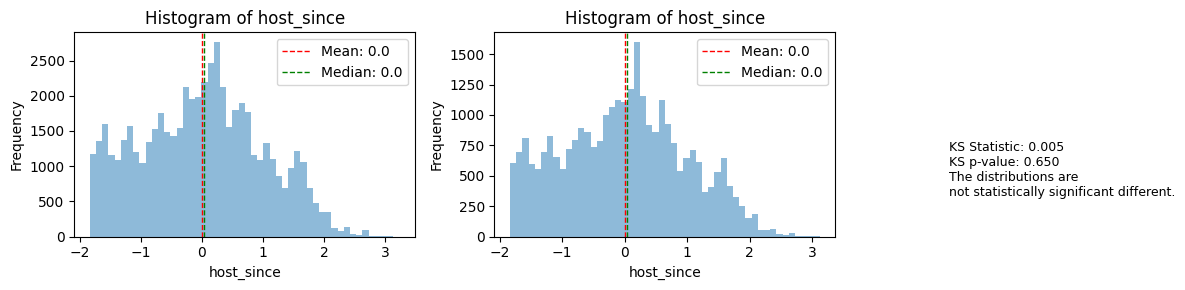

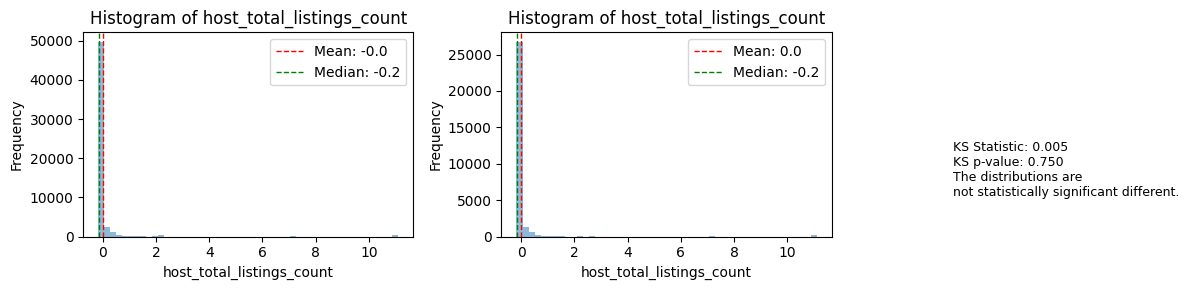

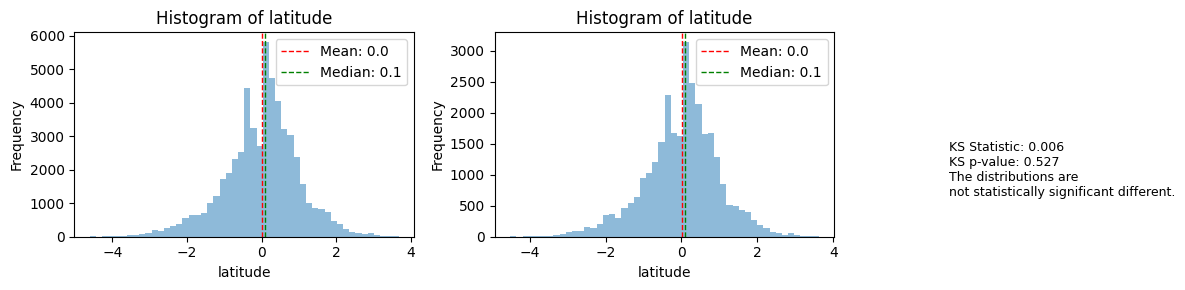

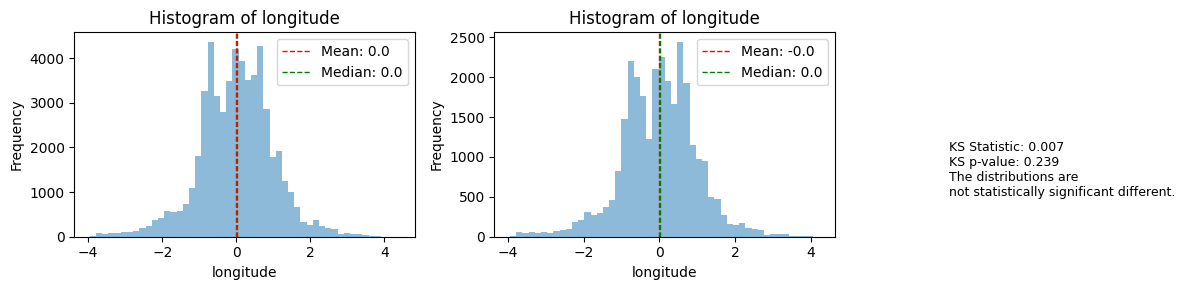

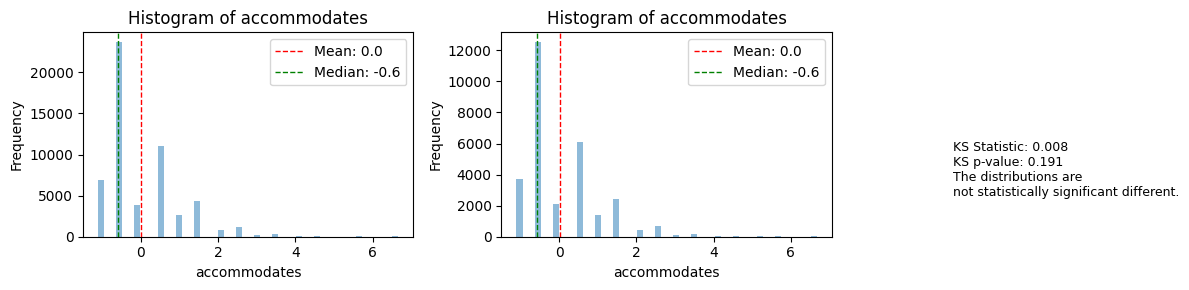

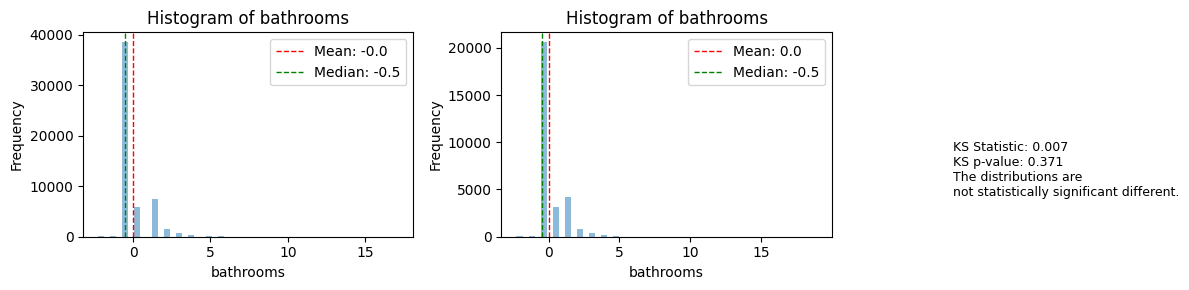

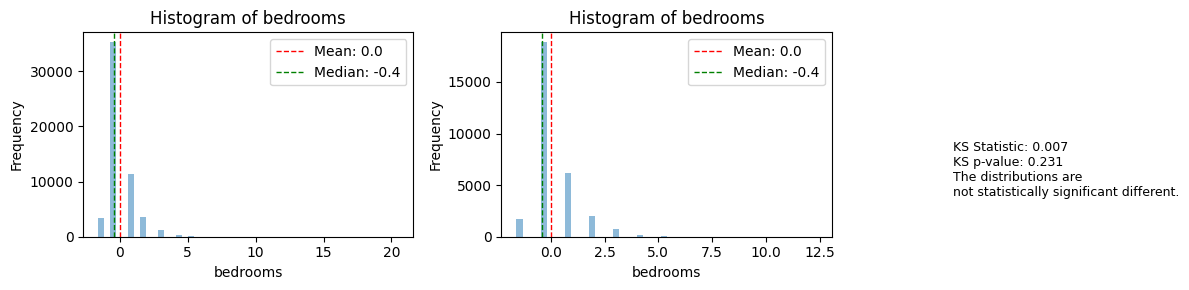

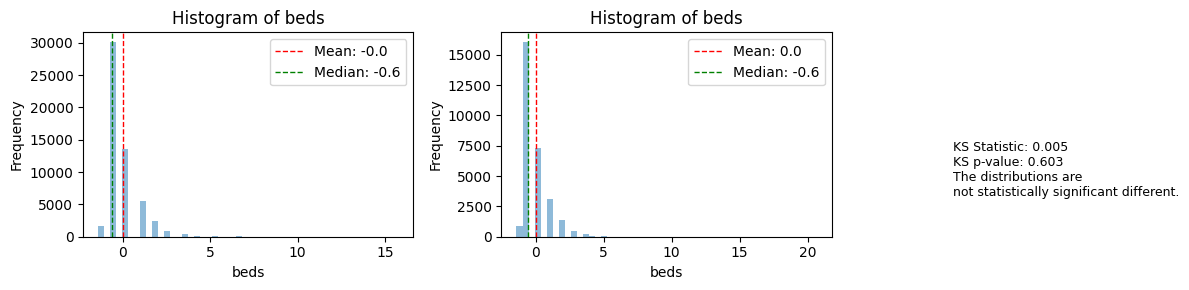

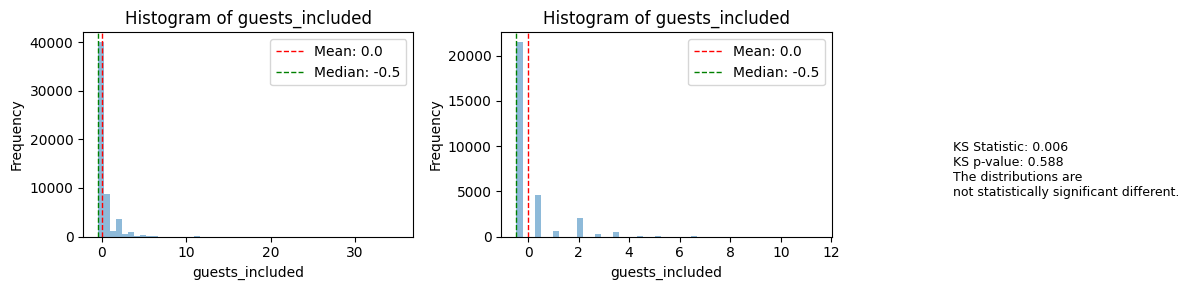

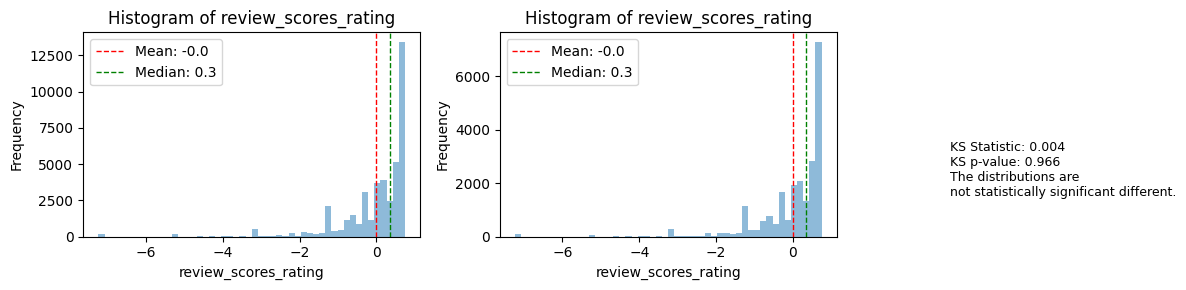

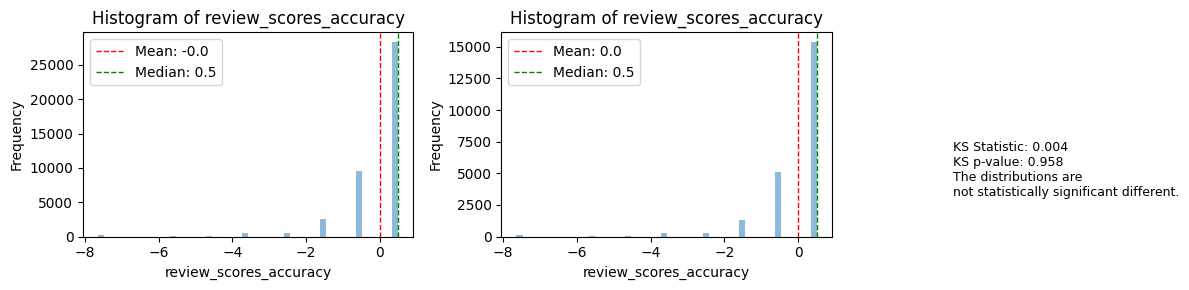

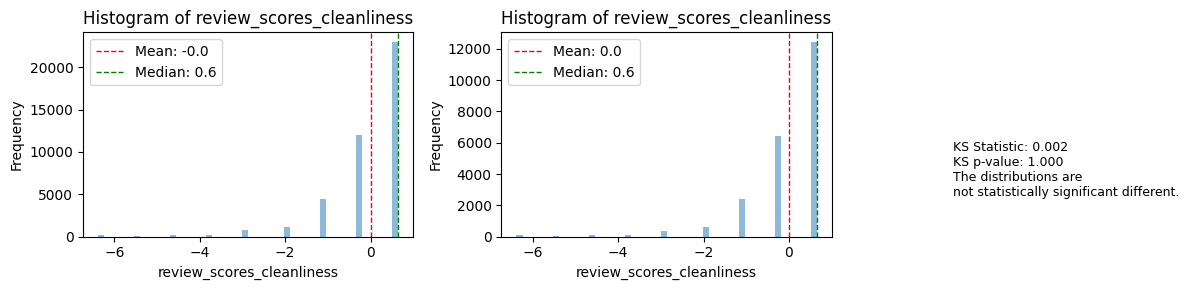

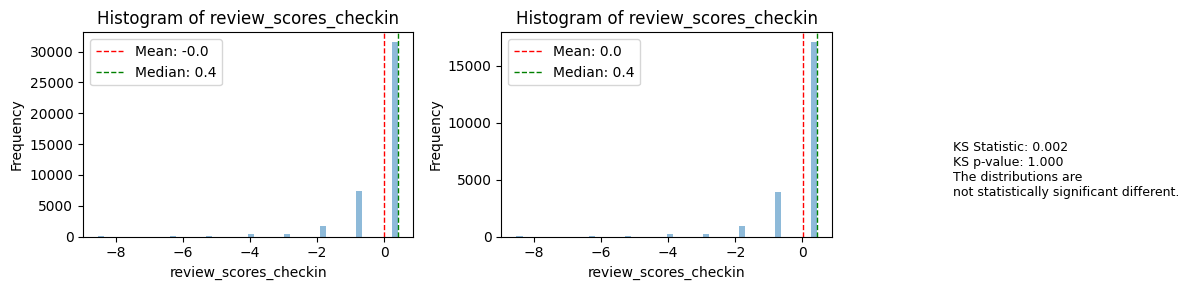

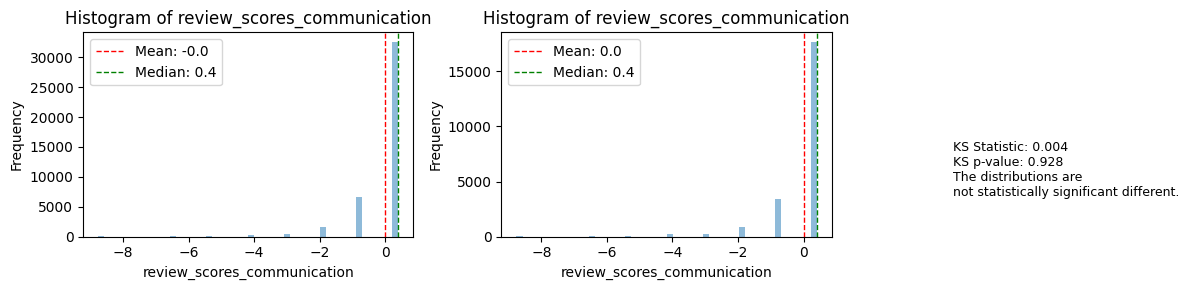

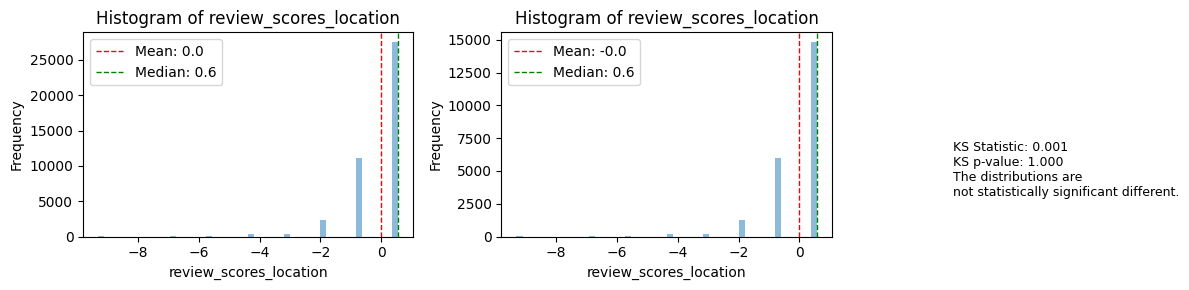

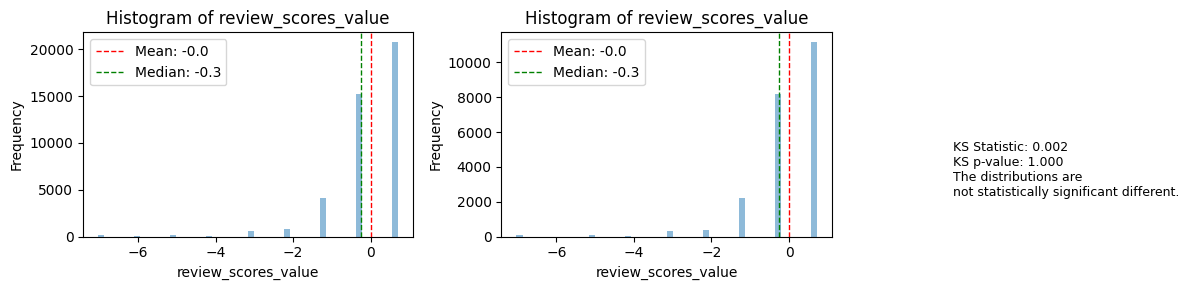

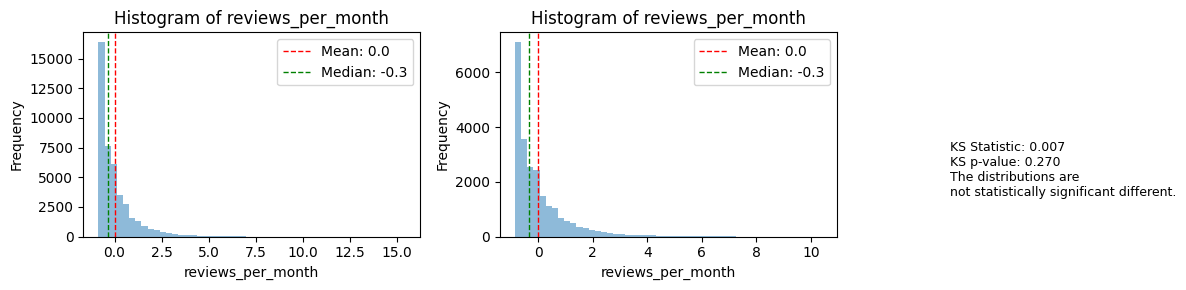

In [51]:
histograms(df_train_num, df_test_num)

We then augment for missing values using the median. From above we know that for some numeric variables the missing values might indicate a non-response bias. We try to account for that via a dummie variables that indicate this bias for all variables where the p-value from the t-test in chapter 4.2 was below the treshold of 0.05.  

In [52]:
#Lists of variables in which missing values contain a bias and in which they don't (depending on p-value < 0.05)
numerical_biased = ["host_since",
                     "host_total_listings_count",
                     "beds",
                     "review_scores_rating",
                     "review_scores_accuracy",
                     "review_scores_cleanliness",
                     "review_scores_checkin",
                     "review_scores_communication",
                     "review_scores_location",
                     "review_scores_value",
                     "reviews_per_month"]

numerical_unbiased = ["latitude",
                     "longitude",
                     "accommodates",
                     "bathrooms",
                     "bedrooms",
                     "guests_included"]

#Augment df_train_num for missing values
#First augment for the missing values in the biased variables
df_train_num = Cleaner.augment4NA_numerical(dataframe=df_train_num,
                                                   column_names=numerical_biased,
                                                   substitution_mode = "median")

#Second augment for the missing values in the unbiased variables
df_train_num = Cleaner.augment4NA_numerical(dataframe=df_train_num,
                                                   column_names=numerical_unbiased,
                                                   substitution_mode = "median",
                                                    make_dummies = "False")

#Augment df_test_num for missing values
#First augment for the missing values in the biased variables
df_test_num = Cleaner.augment4NA_numerical(dataframe=df_test_num,
                                                   column_names=numerical_biased,
                                                   substitution_mode = "median")

#Second augment for the missing values in the unbiased variables
df_test_num = Cleaner.augment4NA_numerical(dataframe=df_test_num,
                                                   column_names=numerical_unbiased,
                                                   substitution_mode = "median",
                                                   make_dummies = "False")

In [53]:
compare_column_names(df_train_num, df_test_num)

,Column Name,Dataframe 1,Dataframe 2,Index,Index (DF1),Index (DF2),Match
0,accommodates,Found,Found,0,4,4,Match
1,bathrooms,Found,Found,1,5,5,Match
2,bedrooms,Found,Found,2,6,6,Match
3,beds,Found,Found,3,7,7,Match
4,beds_NA,Found,Found,4,19,19,Match
5,guests_included,Found,Found,5,8,8,Match
6,host_since,Found,Found,6,0,0,Match
7,host_since_NA,Found,Found,7,17,17,Match
8,host_total_listings_count,Found,Found,8,1,1,Match
9,host_total_listings_count_NA,Found,Found,9,18,18,Match


# 5. Benchmark Models

For our benchmark models we choose Linear Regression, Random Forest, Gradient Boosting and a feed forward neural network.

## 5.1 Set Up

**K-fold cross validation function that works with various models**

In [54]:
def kfold(model, X, y, num_folds=10, random_state=666):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    rmse = []
    rmse_list = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)

        prediction = model.predict(X_val)
        rmse = mean_squared_error(y_val, prediction, squared=False)
        rmse_list.append(rmse)

    mean_rmse = np.mean(rmse_list)
    print(f"Average RMSE: {mean_rmse}")

    return mean_rmse

**Prepare the data for all benchmark models except OLS**

In [55]:
#Concatenate the numerical and categorical variables
df_train_B = pd.concat([df_train_num, df_train_cat], axis=1)
df_test_B = pd.concat([df_test_num, df_test_cat], axis=1)
pd.set_option('display.max_rows', 320)
compare_column_names(df_train_B, df_test_B)

,Column Name,Dataframe 1,Dataframe 2,Index,Index (DF1),Index (DF2),Match
0,accommodates,Found,Found,0,4,4,Match
1,bathrooms,Found,Found,1,5,5,Match
2,bed_type_Airbed,Found,Found,2,111,111,Match
3,bed_type_Couch,Found,Found,3,112,112,Match
4,bed_type_Futon,Found,Found,4,113,113,Match
5,bed_type_Pull-out Sofa,Found,Found,5,114,114,Match
6,bed_type_Real Bed,Found,Found,6,115,115,Match
7,bedrooms,Found,Found,7,6,6,Match
8,beds,Found,Found,8,7,7,Match
9,beds_NA,Found,Found,9,19,19,Match


## 5.2 OLS

OLS models are a well known concept and are a staple statistical model.

In [56]:
df_train_OLS = pd.concat([df_train_num, df_train_cat_OLS], axis=1)

We use k-fold cross validation to evaluate our model. There would be multiple ways to adress various issues of our linear regression model, e.g. we most likely have the issue of multicollinearity. But since this is just a benchmark model and our starting point, we dont delve into that and keep it simple.

In [57]:
#Setup the model
LR = LinearRegression()

kfold(LR, df_train_OLS, y_train)

Average RMSE: 0.4104102543855082


0.4104102543855082

## 5.3 Random Forest
The next benchmark we use is Random Forest. This is a non-linear approach. We got slightly better results when choose different values, e.g. a higher max_depth, but decided against it due to time-consuming computations.

In [58]:
#Create the Random Forest
RF = RandomForestRegressor(
    n_estimators=100,
    criterion="friedman_mse",
    max_depth=8,
    max_samples=0.2,
    random_state=None)

#Use the kfold-function
kfold(RF, df_train_B, y_train, num_folds=4)

Average RMSE: 0.4000503831569836


0.4000503831569836

Compared to the OLS model we have a slightly lower RMSE, when we choose a higher values for 'n_estimators' and 'max_depth' we got an RMSE around 35.

## 5.4 GradientBoosting

Up next we use Gradient Boosting.

In [59]:
#Create the GradientBoosting Regressor
GB = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    random_state=None)

#Use the kfold-function
kfold(GB, df_train_B, y_train, num_folds=4)

Average RMSE: 0.3637553687198893


0.3637553687198893

The result of the Gradient Boosting is slightly better than that of the Random Forest. When we choose higher values for 'n_estimators' or 'max_depth' the results only improved marginally.

## 5.5 Feed Forward Neural Network

The last benchmark model we construct is a feed forward neural network. One interesting thing we notices here was that a dropout or more layers worsened the results. Since the target variable only has positive values, we used the 'relu' activation function for the final layer of this and of all following neural networks.

**Building and training the model**

In [60]:
#Set random seeds for reproducibility
seed_value = 7
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#Set up the data
df_train_FFNN = pd.concat([df_train_num, df_train_cat], axis=1)
df_test_FFNN = pd.concat([df_test_num, df_test_cat], axis=1)

X_train = df_train_FFNN.values
X_test = df_test_FFNN.values
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

num_epochs = 100
batch_size = 64

#Build the model
FFNN = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation="relu",
                          kernel_initializer="he_normal",
                          input_shape=(df_train_FFNN.shape[1],)),
    tf.keras.layers.Dense(1, activation="relu")])

#Define the loss function
loss_ffnn = tf.keras.losses.MeanSquaredError()

#Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

#Compile the model
FFNN.compile(optimizer=optimizer, loss=loss_ffnn)

#Define early stopping callback
early_stopping = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                   patience=10,
                                                   restore_best_weights=True)]

In [61]:
#Train the model
FFNN_history = FFNN.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=early_stopping)

Epoch 1/100
692/692 [==============================] - 8s 4ms/step - loss: 1.0078 - val_loss: 0.2220
Epoch 2/100
692/692 [==============================] - 3s 4ms/step - loss: 0.1986 - val_loss: 0.1816
Epoch 3/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1740 - val_loss: 0.1705
Epoch 4/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1642 - val_loss: 0.1644
Epoch 5/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1582 - val_loss: 0.1612
Epoch 6/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1541 - val_loss: 0.1595
Epoch 7/100
692/692 [==============================] - 3s 4ms/step - loss: 0.1504 - val_loss: 0.1600
Epoch 8/100
692/692 [==============================] - 3s 4ms/step - loss: 0.1479 - val_loss: 0.1559
Epoch 9/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1453 - val_loss: 0.1534
Epoch 10/100
692/692 [==============================] - 2s 3ms/step - loss: 0.1434 - val_lo

**Using kfold**

In [64]:
kfold(FFNN, df_train_FFNN, y_train, num_folds=4)

432/432 [==============================] - 1s 1ms/step
Average RMSE: 0.3454583445224454


0.3454583445224454

The results are not to different from the other benchmark methods.

We then use our model for our first prediction on the testing data. The Kaggle score was around 53.

**Using the model to predict and download the predictions**

In [63]:
#Predict the prices
predicted_prices_FFNN = FFNN.predict(X_test)
predicted_prices_FFNN = np.exp(predicted_prices_FFNN)

#Create a DataFrame
df = pd.DataFrame({'listing_id': df_raw_test['listing_id'], 'price': predicted_prices_FFNN.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_FFNN.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_FFNN.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 2s 2ms/step


# 6. NLPs
We know turn to our Natural Language Processing (NLP) models. First we have a look at our textual data. Then we will define some functions for our preprocessing. We build a model using our own embeddings and and we build several models using GLOVE embeddings. First we will preprocess the data for our own embeddings and then build a model. After that we will preprocess the data and build a model using GLOVE embeddings.

We decided not to use every column for three reasons:
1. The other variables have a very high rate of missing values (above 30%).
2. Not including the other variables led to shorter sequence length, which helped with our limited computational power.
3. Most importantly, when included the predicted results did not change much or even got worse.

We decided to merge the selected text columns into one single text. For that we first define a function.

In [65]:
def make_one_text(dataframe, column_names):
    """
    Function that takes many texts and makes one text out of it.

    dataframe: pandas DataFrame - the input DataFrame.
    column_names: list of str - the names of the columns containing text.

    returns the modified dataframe
    """

    #Make a copy of the subset DataFrame to avoid the SettingWithCopyWarning
    dataframe = dataframe.copy()

    #Convert any non-string elements in the specified columns to string
    dataframe.loc[:, column_names] = dataframe.loc[:, column_names].astype(str)

    #Join the text from the specified columns using a space separator
    dataframe["merged_text"] = dataframe[column_names].apply(lambda row: ' '.join(row), axis=1)

    dataframe["merged_text"] = dataframe["merged_text"].astype(str)

    return dataframe

We then apply the function and store the newly created 'merged_text' column in the 'df_train_NLP' and 'df_test_NLP'.

In [66]:
#List of the choosen text columns
text_columns = ["name",
                "summary",
                "space",
                "description"]

df_train_text = df_train[text_columns]
df_test_text = df_test[text_columns]

#Apply make_one_text
df_train_NLP = make_one_text(df_train_text, text_columns)
df_test_NLP = make_one_text(df_test_text, text_columns)

df_train_NLP = df_train_NLP.loc[:, "merged_text"]
df_test_NLP = df_test_NLP.loc[:, "merged_text"]

## 6.1 EDA for the Textual Data
Before we start with the preprocessing, we want to gain insight into our text data. We start with having a look at the average number of words in each row and at how many words the longest row contains.

In [67]:
#df_train_NLP
#Tokenize each row and store the tokenized sequences in a new list
tokenized_rows = [word_tokenize(text) for text in df_train_NLP]

#Calculate the total number of tokens and the number of rows
total_tokens = sum(len(tokens) for tokens in tokenized_rows)
num_rows = len(tokenized_rows)

#Calculate the average number of tokens per row
average_tokens_per_row = total_tokens / num_rows
longest_row_length = max(len(tokens) for tokens in tokenized_rows)

print("The average tokens per row in df_train_NLP is:", average_tokens_per_row)
print("The longest row has a lenght of:", longest_row_length)

#df_test_NLP
#Tokenize each row and store the tokenized sequences in a new list
tokenized_rows_test = [word_tokenize(text) for text in df_test_NLP]

#Calculate the total number of tokens and the number of rows
total_tokens_test = sum(len(tokens) for tokens in tokenized_rows_test)
num_rows_test = len(tokenized_rows_test)

#Calculate the average number of tokens per row
average_tokens_per_row_test = total_tokens_test / num_rows_test
longest_row_length_test = max(len(tokens) for tokens in tokenized_rows_test)

print("The average tokens per row in df_test_NLP is:", average_tokens_per_row_test)
print("The longest row has a lenght of:", longest_row_length_test)

The average tokens per row in df_train_NLP is: 285.79370161348675
The longest row has a lenght of: 749
The average tokens per row in df_test_NLP is: 286.6406664651147
The longest row has a lenght of: 678


We then look at the distribution of the number of tokens per observation. For our sequence length we determined the 99th percentile of words per observation as a cutoff. Due to the removal of stopwords etc. we will later again calculate the 99th percentile.

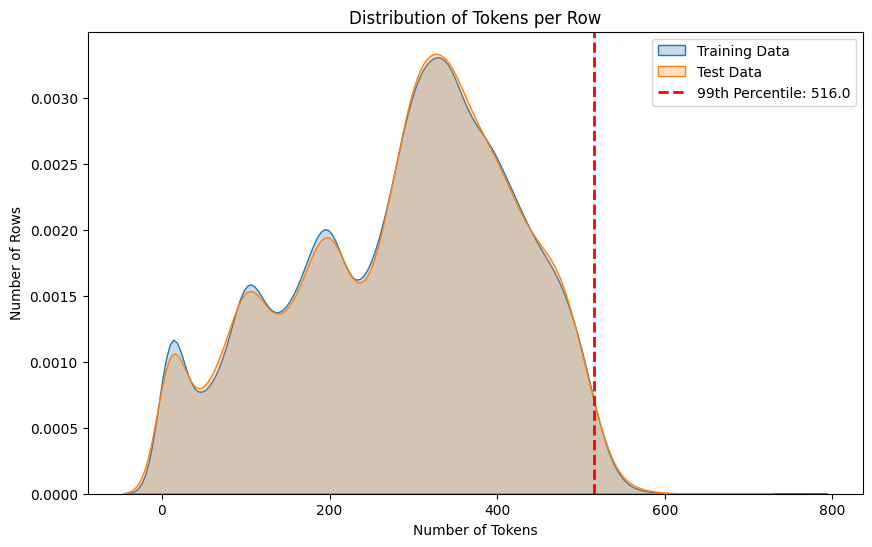

In [68]:
#Create a list of the number of token
token_counts = [len(tokens) for tokens in tokenized_rows]
token_counts_test = [len(tokens) for tokens in tokenized_rows_test]

#Calculate the 95th percentile
percentile_99 = np.percentile(token_counts, 99)

#Create a plot
plt.figure(figsize=(10, 6))
sns.kdeplot(token_counts, label="Training Data", fill=True)
sns.kdeplot(token_counts_test, label="Test Data", fill=True)
plt.axvline(x=percentile_99, color="red", linestyle="dashed", linewidth=2, label=f"99th Percentile: {percentile_99}")

plt.xlabel("Number of Tokens")
plt.ylabel("Number of Rows")
plt.title("Distribution of Tokens per Row")
plt.legend()

plt.show()

The distributions are very similar. We then look at the number of unique tokens in both datasets.

In [69]:
#data_train_NLP
#Create a set to store all unique tokens
unique_tokens_set = set()

# Add all tokens to the set
for tokens in tokenized_rows:
    unique_tokens_set.update(tokens)

#Calculate the total number of unique tokens
total_unique_tokens = len(unique_tokens_set)

print("Total number of unique tokens in df_train_NLP:", total_unique_tokens)

#data_test_NLP
#Create a set to store all unique tokens
unique_tokens_set_test = set()

#Add all tokens to the set
for tokens in tokenized_rows_test:
    unique_tokens_set_test.update(tokens)

#Calculate the total number of unique tokens
total_unique_tokens_test = len(unique_tokens_set_test)

print("Total number of unique tokens in df_test_NLP:", total_unique_tokens_test)

Total number of unique tokens in df_train_NLP: 85048
Total number of unique tokens in df_test_NLP: 60076


There is a huge discrepancy between the vocabulary of the train and testing data. This becomes problematic when building a model with self-trained embeddings, as it exposes the model to numerous words absent in the test dataset. However, this concern diminishes when opting for pre-trained embeddings with a 'non-trainable' setting. This approach is advantageous due to the inherent similarity in embedding vectors for semantically related words, requiring us to solely focus on refining the model's weights and biases.

Then we look at the tokens that consist only of one or two characters in the training data.

In [70]:
#Create a set to store short words
short_words = set()

#Iterate through each tokenized row
for tokens in tokenized_rows:
    for token in tokens:
        if len(token) <= 2:
            short_words.add(token)

print(f"The number of tokens with one or two characters: {len(short_words)}")
short_words

The number of tokens with one or two characters: 1912


{'UR',
 '超市',
 ';',
 'W3',
 'bw',
 'À',
 '혹은',
 '막상',
 'NA',
 '3분',
 '8m',
 'Mu',
 '毛巾',
 '완전',
 'F5',
 '접근',
 '6S',
 'EG',
 'A.',
 'Fa',
 'S2',
 '✨',
 '59',
 'K3',
 '57',
 'RD',
 'So',
 'Ga',
 'до',
 'H9',
 'аs',
 '것은',
 '4B',
 '公交',
 '71',
 'Gu',
 '정도',
 'N9',
 '~7',
 'np',
 '-a',
 'or',
 '2B',
 '7x',
 '3a',
 'tv',
 'b.',
 'B7',
 'OK',
 'NR',
 '워낙',
 '8번',
 '새로',
 'U4',
 '분이',
 '£9',
 'An',
 './',
 '.A',
 '4-',
 '16',
 'EN',
 'XL',
 'HF',
 'ti',
 '✯A',
 '——',
 'Vi',
 'Nu',
 '伦敦',
 'DP',
 '부엌',
 'SS',
 'f3',
 '1.',
 'n8',
 'EL',
 'BG',
 'cl',
 'm',
 'FM',
 'Au',
 'F3',
 '№9',
 '다들',
 '2K',
 '몇',
 '유명',
 '烤箱',
 'TW',
 'Wa',
 'G1',
 'Jo',
 'N7',
 '快餐',
 'IQ',
 '2C',
 '8L',
 '69',
 'E6',
 '8-',
 '?',
 '-6',
 'CB',
 '当然',
 'Ar',
 '97',
 'T1',
 'ca',
 'Pp',
 'ro',
 'U7',
 'e.',
 'DC',
 '4£',
 'M3',
 'W2',
 '친구',
 'bd',
 'LC',
 '中',
 '₄',
 '교통',
 '5M',
 '--',
 '25',
 'Bo',
 'le',
 'FT',
 'ct',
 'z',
 'R3',
 'I.',
 '-K',
 '46',
 'من',
 '/7',
 '…',
 'EV',
 'W5',
 '❥',
 'LB',
 'w.',
 'C4',
 '2

There seem to be many 'nonsense' tokens in the data. We will take care of this during the preprocessing. At last we have a look at how often each word is in the data

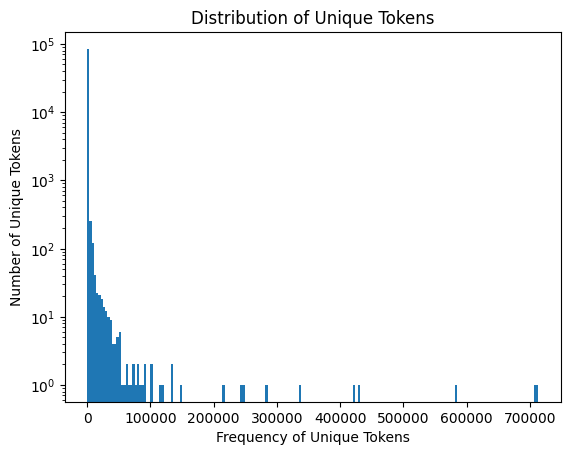

In [71]:
#Flatten the tokenized_rows list into a single list of all tokens
all_tokens = [token for tokens in tokenized_rows for token in tokens]

#Calculate the frequency of each unique token
token_counter = Counter(all_tokens)

#Get the frequency values
token_frequencies = list(token_counter.values())

#Plot the histogram
plt.hist(token_frequencies, bins=200, log=True)
plt.xlabel("Frequency of Unique Tokens")
plt.ylabel("Number of Unique Tokens")
plt.title("Distribution of Unique Tokens")
plt.show()

As seen on the x-axis the majority of words will be found very rarely in the data. This is another argument for using pre-trained embeddings.

## 6.2 Functions for Preprocessing
Before we preprocess and build our models we define some functions for the preprocessing. Most functions and steps taken are very basic, e.g. removing NLTK stopwords. For the models using pre-trained embeddings two additional decisions were made:
1. Due to the high number of 'nonsense' words that have one or two characters, we remove all words with less than three characters.
2. We lemmatize the words, since the majority of words has a very low occurence. Through lemmatization and using pre-trained embeddings we try to diminish the negative effect of the low occurences.

**Functions for preprocessing:**

In [72]:
#Change text to lowercase
def change_lower(text):
    text = text.lower()
    return text

#Remove stopwords
stopwords_list = set(stopwords.words("english"))
def remove_stopwords(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if not word in stopwords_list]
    text = ' '.join(final_list)
    return text

#Remove punctuation
def remove_punctuation(text):
    pattern_remove_punctuation = "[%s]" % re.escape(string.punctuation)
    text = re.sub(pattern_remove_punctuation, '', text)
    return text

#Remove double spaces
def remove_double_spaces(text):
    text = re.sub(r"\s+", " ", text)
    return text

#Remove words with 1 or 2 characters
def remove_short_words(text):
    text_tokens = text.split(" ")
    final_list = [word for word in text_tokens if len(word) > 2]
    text = ' '.join(final_list)
    return text

#Lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    text_tokens = text.split(" ")
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in text_tokens]
    text = " ".join(lemmatized_tokens)
    return text

#Put all the functions together
def preprocess_text(text):
    text = change_lower(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_double_spaces(text)
    text = remove_short_words(text)
    text = lemmatize_text(text)
    return text

In [73]:
def standardization(text_data):
    text = tf.strings.lower(text_data)
    pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation)
    text = tf.strings.regex_replace(text, pattern_remove_punctuation, '')
    text = tf.strings.regex_replace(text, '\s+', ' ')
    return text

## 6.3 Apply 'preprocess_text'

Since we designe functions for the preprocessing of our data when we use pre-trained embeddings, we didnt include all the steps in the standardization function for the model with no pre-trained embeddings. We apply this function now and will use 'data_train_NLP' and 'data_test_NLP' as the foundation for the further preprocessing.

In [74]:
#Preprocess training data
data_train_NLP = df_train_NLP
data_train_NLP = data_train_NLP.astype(str)
data_train_NLP = data_train_NLP.apply(preprocess_text)

#Preprocess test data
data_test_NLP = df_test_NLP
data_test_NLP = data_test_NLP.astype(str)
data_test_NLP = data_test_NLP.apply(preprocess_text)

In [75]:
tokenized_rows_A = [word_tokenize(text) for text in data_train_NLP]
token_counts = [len(tokens) for tokens in tokenized_rows_A]
percentile_99_A = np.percentile(token_counts, 99)
print(f"The sequence length determined by the 99th percentile should be: {percentile_99_A}")

sequence_length = int(percentile_99_A)

#data_train_NLP
#Create a set to store all unique tokens
unique_tokens_set = set()

# Add all tokens to the set
for tokens in tokenized_rows_A:
    unique_tokens_set.update(tokens)

#Calculate the total number of unique tokens
total_unique_tokens = len(unique_tokens_set)

print("Total number of unique tokens in preprocessed data_train_NLP:", total_unique_tokens)

The sequence length determined by the 99th percentile should be: 274.0
Total number of unique tokens in preprocessed data_train_NLP: 61426


## 6.4 Model With No Pre-Trained Embeddings
Before we build and train our model we are using the TextVectorization layer to preprocess text data for a natural language processing (NLP) task. The vectorization layer is set up with parameters and then it is adapted to the training data. The parameters are based on the calculated values above. The desired length of the sequences are based on the 99th percentile of sequence. The size of the vocabulary is the based on the size of unique tokens in the preprocessed text data.

After this we build and train our model. We choose a Bidirectional Gated Recurrent Unit (BiGRU) architecture. A BiGRU is a neural network architecture widely used in NLP tasks. It processes sequences in both forward and backward directions, enabling it to capture contextual information and dependencies between words. This bidirectional modelling alleviates vanishing gradient issues from which non-Bidirectional Recurrent Neural Networks (RNN) often suffer.

**Application of TextVectorization:**

In [76]:
#Use values from above
vocab_size = total_unique_tokens
seq_length = sequence_length

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens=vocab_size,
    output_sequence_length=seq_length
)

vectorize_layer.adapt(data_train_NLP)
vocab = vectorize_layer.get_vocabulary()
print(vocab[:1000])

['', '[UNK]', 'room', 'london', 'bedroom', 'flat', 'bed', 'walk', 'apartment', 'kitchen', 'minute', 'station', 'double', 'bathroom', 'area', 'house', 'living', 'large', 'central', 'min', 'floor', 'park', 'garden', 'street', 'guest', 'located', 'home', 'space', 'one', 'spacious', 'away', 'modern', 'also', 'access', 'private', 'restaurant', 'two', 'close', 'tube', 'great', 'bus', 'place', 'stay', 'quiet', 'available', 'lovely', 'fully', 'comfortable', 'beautiful', 'shop', 'well', 'city', 'bright', 'sofa', 'location', 'shower', 'road', 'equipped', 'family', 'perfect', 'high', 'line', 'within', 'use', 'wifi', 'dining', 'nan', 'free', 'transport', 'walking', 'towel', 'property', 'light', 'need', 'heart', 'open', 'new', 'table', 'train', 'bar', 'king', 'distance', 'good', 'studio', 'easy', 'view', 'clean', 'link', 'coffee', 'cosy', 'local', 'people', 'single', 'enjoy', 'market', 'please', 'linen', 'shared', 'machine', 'offer', 'building', 'amenity', 'centre', 'small', 'short', 'couple', 'und

In [77]:
X_train_NLP = vectorize_layer(data_train_NLP)
X_test_NLP = vectorize_layer(data_test_NLP)
y_train_NLP = tf.convert_to_tensor(y_train)

**Building, compiling and training the model**

Extensive hyperparameter search was conducted and evaluated using Kaggle-scores. A higher number of neurons resulted in better results but also impacted run-time heavily. Since the results of every model with no pre-trained embeddings are worse than those with pre-trained embeddings, the number was not kept at the optimum but lower. The best results with this model on Kaggle were found with 256 and 512 neurons. After a certain level for the embeddings size was reached, the results did not imporve much when we used an even bigger embedding size.

In [78]:
emb_size = 100

input_NLP_1 = tf.keras.Input(shape=(seq_length,), dtype="int64")
emb = layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(input_NLP_1)
x = layers.Bidirectional(layers.GRU(128))(emb)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="relu")(x)
NLP_1 = tf.keras.Model(input_NLP_1, output)

NLP_1.compile(optimizer="adam",
              loss="mean_squared_error")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience = 3,
                                              restore_best_weights = True)]

NLP_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 274)]             0         
                                                                 
 embedding (Embedding)       (None, 274, 100)          6142600   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              176640    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,319,497
Trainable params: 6,319,497
Non-trainable params: 0
___________________________________________________

**Fitting the model**

In [79]:
NLP_1.fit(
    X_train_NLP,
    y_train_NLP,
    epochs = 10,
    batch_size = 64,
    validation_split=0.15,
    callbacks=[early_stopping])

Epoch 1/10
735/735 [==============================] - 104s 127ms/step - loss: 0.6988 - val_loss: 0.2199
Epoch 2/10
735/735 [==============================] - 37s 51ms/step - loss: 0.2719 - val_loss: 0.2145
Epoch 3/10
735/735 [==============================] - 32s 44ms/step - loss: 0.2328 - val_loss: 0.2341
Epoch 4/10
735/735 [==============================] - 28s 38ms/step - loss: 0.2137 - val_loss: 0.2193
Epoch 5/10
735/735 [==============================] - 28s 39ms/step - loss: 0.1931 - val_loss: 0.2331
Epoch 6/10
735/735 [==============================] - 26s 36ms/step - loss: 0.1780 - val_loss: 0.2399
Epoch 7/10
735/735 [==============================] - 25s 34ms/step - loss: 0.1629 - val_loss: 0.2258
Epoch 8/10
735/735 [==============================] - 27s 36ms/step - loss: 0.1502 - val_loss: 0.2197
Epoch 9/10
735/735 [==============================] - 25s 34ms/step - loss: 0.1395 - val_loss: 0.2283
Epoch 10/10
735/735 [==============================] - 25s 34ms/step - loss: 0.1

The big difference between the loss and validation loss stands out. The model with trainable embeddings seems to overfit using the changeable embeddings.

**Using the model to predict and download the predictions**

In [80]:
predicted_prices_NLP_1 = NLP_1.predict(X_test_NLP)
predicted_prices_NLP_1 = np.exp(predicted_prices_NLP_1)
#Create a DataFrame
df = pd.DataFrame({"listing_id": df_raw_test["listing_id"], "price": predicted_prices_NLP_1.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_NLP_1.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_NLP_1.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 11s 9ms/step


## 6.5 Preprocessing with GLOVE

Before we use pre-trained embeddings and build and train our NLP models we need to convert the raw text data into a format that machines can understand and process. We use 'Tokenizer' and fit it on the words in our training data. The word 'word index' maps each word to a unique number. Based on this index we convert our texts into sequences of numbers. Via padding and truncation we ensure that all sequences have the same length.

We prepare the data twice since we want to create testing data for our models that run purely on textual data but we want to train our final models on the whole dataset.

In [81]:
text_train, text_val, y_train_2, y_val, num_cat_train, num_cat_val = train_test_split(data_train_NLP,
                                                                                      y_train,
                                                                                      df_train_B,
                                                                                      test_size=0.1,
                                                                                      random_state=666)
y_val = np.exp(y_val)

In [82]:
vocab_size = total_unique_tokens
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(data_train_NLP)

In [83]:
word_index = tokenizer.word_index

In [84]:
X_train_sequences = tokenizer.texts_to_sequences(text_train)
X_val_sequences = tokenizer.texts_to_sequences(text_val)
X_test_sequences = tokenizer.texts_to_sequences(data_test_NLP)

In [85]:
seq_length = sequence_length
padding_type="post"
truncation_type="post"

X_test_padded = pad_sequences(X_test_sequences,
                              maxlen=seq_length,
                              padding=padding_type,
                              truncating=truncation_type)

X_val_padded = pad_sequences(X_val_sequences,
                             maxlen=seq_length,
                             padding=padding_type,
                             truncating=truncation_type)

X_train_padded = pad_sequences(X_train_sequences,
                               maxlen=seq_length,
                               padding=padding_type,
                               truncating=truncation_type)

**Data for the final models**

In [86]:
X_train_Final = tokenizer.texts_to_sequences(data_train_NLP)
X_test_Final = tokenizer.texts_to_sequences(data_test_NLP)

In [87]:
seq_length = sequence_length
padding_type="post"
truncation_type="post"

X_test_padded_Final = pad_sequences(X_test_sequences,maxlen=seq_length,
                               padding=padding_type, truncating=truncation_type)

X_train_padded_Final = pad_sequences(X_train_sequences,maxlen=seq_length, padding=padding_type,
                       truncating=truncation_type)

For our pretrained embeddings we decided to use GloVe (https://nlp.stanford.edu/projects/glove/). One of the main reasons is that the vector represantation of words have similar representation for similar words. This is very useful since many words in our data have a low occurence. From the website: "The Euclidean distance (or cosine similarity) between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words."

**Downloading and saving the GloVe pre-trained word vectors dataset**

In [88]:
url = "http://nlp.stanford.edu/data/glove.6B.zip"
output_path = "glove.6B.zip"  # Save the file in the current working directory

response = requests.get(url, stream=True)
with open(output_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

**Extracting Contents**

In [89]:
with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("/tmp/glove")

**Loading GloVe Word Embeddings and Building a Word Vectors Index**

In [90]:
embeddings_index = {}
f = open("/tmp/glove/glove.6B.100d.txt", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## 6.6 Models using Pre-Trained Embeddings

Next we train NLP models using pre-trained embeddings. The first two models were build using a GRU and a LSTM architecture and vice versa. This seemed to have no impact on the predictive power of the models. When we used the full, unpartioned training dataset to train the models, we achieved Kaggel scores between 50 and 60. In order not to overcrowd the notebook, all these other models were not included.

For our hyperparameter search we used different layer architecture, different regularization techniques, different number of neurons and different optimizers. Since the choice of optimizers made little to no difference we decided to always use 'adam'. Except for absurd values the choice of learning rate had little to no impact on our results. To our suprise deeper models (e.g. more transformer blocks) worsened our results.

Before we build and fit our models we create an embedding matrix using pre-trained GloVe embeddings.

In [91]:
max_length = 100 #Dimensionality of the pre-trained embeddings
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #Words not found in embedding index will all be zeros
        embedding_matrix[i] = embedding_vector

### 6.6.1 BiGRU
We use a very similar architecture to the neural network without pre-trained embeddings. This allows us to evaluate the impact of using pre-trained embeddings. The results, measured by Kaggle scores, improved strongly from a a score of aroud 80 without pre-trained embeddings to a score around 55 to 60.

**Building, compiling and training the BiGRU model**

In [92]:
Input_BiGRU = Input(shape=(sequence_length,))

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False,
                            mask_zero=True)(Input_BiGRU)

x = Bidirectional(layers.GRU(512, return_sequences=False))(embedding_layer)
x = layers.Dropout(0.5)(x)
output_layer = Dense(1, activation="relu")(x)

BiGRU = Model(inputs=Input_BiGRU, outputs=output_layer)

BiGRU.compile(loss="mean_squared_error", optimizer="adam")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)]

BiGRU.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 274)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 274, 100)          6256500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             1886208   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 8,143,733
Trainable params: 1,887,233
Non-trainable params: 6,256,500
_________________________________________

In [93]:
hist_BiGRU = BiGRU.fit(X_train_padded,
                     y_train_2,
                     epochs = 10,
                     batch_size = 64,
                     validation_split = 0.2,
                     callbacks= callbacks)

Epoch 1/10
622/622 [==============================] - 65s 85ms/step - loss: 0.4583 - val_loss: 0.2798
Epoch 2/10
622/622 [==============================] - 51s 82ms/step - loss: 0.2793 - val_loss: 0.2316
Epoch 3/10
622/622 [==============================] - 52s 84ms/step - loss: 0.2557 - val_loss: 0.2228
Epoch 4/10
622/622 [==============================] - 54s 87ms/step - loss: 0.2363 - val_loss: 0.2075
Epoch 5/10
622/622 [==============================] - 53s 85ms/step - loss: 0.2245 - val_loss: 0.2080
Epoch 6/10
622/622 [==============================] - 52s 84ms/step - loss: 0.2141 - val_loss: 0.2082
Epoch 7/10
622/622 [==============================] - 54s 86ms/step - loss: 0.2057 - val_loss: 0.2191


In contrast to the model without pre-trained embeddings the difference between the 'loss' and 'val_loss' is smaller when using pre-trained embeddings. This can be seen as an indicator for overfitting by the model without pre-trained embeddings. It is unsuprising that the model without pre-trained embeddings is not generalizable due to the low occurence of the majority of words.

**Calculating the RMSE for the validation data**

In [94]:
RMSE_prices = BiGRU.predict(X_val_padded)
RMSE_prices = np.exp(RMSE_prices)
RMSE_prices = RMSE_prices.flatten()
squared_diff = (RMSE_prices - y_val) ** 2
mse = np.mean(squared_diff)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

173/173 [==============================] - 10s 21ms/step
RMSE: 61.74798962499031


**Using the model to predict on the test data and download the results**

In [95]:
predicted_prices_BiGRU = BiGRU.predict(X_test_padded)
predicted_prices_BiGRU = np.exp(predicted_prices_BiGRU)

#Create a DataFrame
df = pd.DataFrame({"listing_id": df_raw_test["listing_id"], "price": predicted_prices_BiGRU.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_BiGRU.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_BiGRU.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 19s 20ms/step


### 6.6.2 Deep BiLSTM

If our data contains deeper contextual information and less sentimental information a deeper BiLSTM model might give us better results.

**Building, compiling and training the Deep BiLSTM model**

In [96]:
Input_DeepBiLSTM = Input(shape=(sequence_length,))

embedding_layer_deep = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False,
                            mask_zero=True)(Input_DeepBiLSTM)

DeepBiLSTM = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer_deep)
DeepBiLSTM = layers.Dropout(0.5)(DeepBiLSTM)
DeepBiLSTM = Bidirectional(LSTM(128))(DeepBiLSTM)
dense_DeepBiLSTM = Dense(16, activation="relu")(DeepBiLSTM)
output_layer = Dense(1, activation="relu")(dense_DeepBiLSTM)

DeepBiLSTM = Model(inputs=Input_DeepBiLSTM,
                   outputs=output_layer)

DeepBiLSTM.compile(loss="mean_squared_error",
                   optimizer="adam")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)]

DeepBiLSTM.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 274)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 274, 100)          6256500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 274, 512)         731136    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 274, 512)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 16)                4112

In [97]:
history_DeepBiLSTM = DeepBiLSTM.fit(X_train_padded,
                         y_train_2,
                         epochs=50,
                         batch_size=64,
                         validation_split=0.2,
                         callbacks=callbacks)

Epoch 1/50
622/622 [==============================] - 85s 101ms/step - loss: 0.3645 - val_loss: 0.2498
Epoch 2/50
622/622 [==============================] - 54s 87ms/step - loss: 0.2405 - val_loss: 0.2315
Epoch 3/50
622/622 [==============================] - 57s 92ms/step - loss: 0.2247 - val_loss: 0.2159
Epoch 4/50
622/622 [==============================] - 66s 106ms/step - loss: 0.2047 - val_loss: 0.2080
Epoch 5/50
622/622 [==============================] - 55s 88ms/step - loss: 0.1932 - val_loss: 0.1990
Epoch 6/50
622/622 [==============================] - 54s 87ms/step - loss: 0.1833 - val_loss: 0.1979
Epoch 7/50
622/622 [==============================] - 56s 89ms/step - loss: 0.1730 - val_loss: 0.1980
Epoch 8/50
622/622 [==============================] - 54s 87ms/step - loss: 0.1679 - val_loss: 0.2000
Epoch 9/50
622/622 [==============================] - 63s 101ms/step - loss: 0.1546 - val_loss: 0.1985


**Calculating the RMSE for the validation data**

In [98]:
RMSE_prices = DeepBiLSTM.predict(X_val_padded)
RMSE_prices = np.exp(RMSE_prices)
RMSE_prices = RMSE_prices.flatten()
squared_diff = (RMSE_prices - y_val) ** 2
mse = np.mean(squared_diff)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

173/173 [==============================] - 12s 33ms/step
RMSE: 62.19905070073038


The RMSE is marginally different from the BiGRU model above. The textual data thus seems to contain very little contextual information.

**Using the model to predict on the test data and download the results**

In [100]:
predicted_prices_DeepBiLSTM = DeepBiLSTM.predict(X_test_padded)
predicted_prices_DeepBiLSTM = np.exp(predicted_prices_DeepBiLSTM)
#Create a DataFrame
df = pd.DataFrame({"listing_id": df_raw_test["listing_id"], "price": predicted_prices_DeepBiLSTM.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_BiLSTM.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_BiLSTM.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 25s 26ms/step


### 6.6.3 Transformer

For the last pure NLP model we use a transformer architecture. For this we adapted a model that can be found here: https://keras.io/examples/timeseries/timeseries_transformer_classification/
Transformers are a type of deep learning architecture used for working with sequences. They use a technique called 'self-attention mechanism'. This approach replaces the need for recurrent connections, resulting in faster training and better long-range context understanding. Transformers consist of an encoder and decoder. Though the architecture that we build here only consists of an encoder.

**Building the encoder and the transformer**

In [101]:
def transformer_encoder(inputs,
                        head_size,
                        num_heads,
                        ff_dim,
                        dropout=0,
                        attention_axes=None):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size,
                                  num_heads=num_heads,
                                  dropout=dropout,
                                  attention_axes=attention_axes)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    #Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transfromer(head_size,
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units,
                      dropout=0,
                      mlp_dropout=0) -> tf.keras.Model:
    """Creates final model by building many transformer blocks."""

    inputs = Input(shape=(sequence_length,))
    x = Embedding(input_dim=len(word_index) + 1,
                  output_dim=max_length,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False,
                  mask_zero=True)(inputs)

    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="relu")(x)
    return tf.keras.Model(inputs, outputs)

**Building, compiling and training a Transformer Neural Network**

In [102]:
transformer = build_transfromer(head_size = 256,
                                num_heads = 4,
                                ff_dim = 2,
                                num_trans_blocks = 1,
                                mlp_units = [512],
                                mlp_dropout = 0.10,
                                dropout=0.10)

transformer.compile(loss = "mse",
                    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics = ["mae"])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=10,
                                              restore_best_weights=True)]

transformer.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 274)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 274, 100)     6256500     ['input_4[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 274, 100)    200         ['embedding_3[0][0]']            
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 274, 100)    412772      ['layer_normalization[0][0]

In [103]:
t_hist = transformer.fit(X_train_padded,
                         y_train_2,
                         epochs=50,
                         batch_size=64,
                         validation_split=0.1,
                         verbose=1,
                         callbacks=callbacks)

Epoch 1/50
700/700 [==============================] - 61s 73ms/step - loss: 0.5433 - mae: 0.5331 - val_loss: 0.3487 - val_mae: 0.4715
Epoch 2/50
700/700 [==============================] - 50s 72ms/step - loss: 0.3139 - mae: 0.4352 - val_loss: 0.3862 - val_mae: 0.5017
Epoch 3/50
700/700 [==============================] - 49s 71ms/step - loss: 0.2882 - mae: 0.4159 - val_loss: 0.2946 - val_mae: 0.4300
Epoch 4/50
700/700 [==============================] - 51s 72ms/step - loss: 0.2691 - mae: 0.4013 - val_loss: 0.2733 - val_mae: 0.4137
Epoch 5/50
700/700 [==============================] - 49s 70ms/step - loss: 0.2537 - mae: 0.3901 - val_loss: 0.2421 - val_mae: 0.3799
Epoch 6/50
700/700 [==============================] - 49s 70ms/step - loss: 0.2479 - mae: 0.3853 - val_loss: 0.2351 - val_mae: 0.3725
Epoch 7/50
700/700 [==============================] - 49s 71ms/step - loss: 0.2298 - mae: 0.3693 - val_loss: 0.2196 - val_mae: 0.3547
Epoch 8/50
700/700 [==============================] - 50s 72ms

**Calculating the RMSE for the validation data**

In [105]:
RMSE_prices = transformer.predict(X_val_padded)
RMSE_prices = np.exp(RMSE_prices)
RMSE_prices = RMSE_prices.flatten()
squared_diff = (RMSE_prices - y_val) ** 2
mse = np.mean(squared_diff)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

173/173 [==============================] - 2s 13ms/step
RMSE: 62.40408938403219


**Using the model to predict on the test data and download the results**

In [106]:
predicted_prices_transformer = transformer.predict(X_test_padded)
predicted_prices_transformer = np.exp(predicted_prices_transformer)
#Create a DataFrame
df = pd.DataFrame({"listing_id": df_raw_test["listing_id"], "price": predicted_prices_transformer.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_transformer.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_transformer.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 11s 12ms/step


# 7. Final Models

For our final models we decided to use textual data and non-textual data. The non-textual data delivered our best results so far. We decided to use one Transformer model and one BiGRU model. We will train these models on the textual data first and then concatenate an output of these models with the numerical and categorical data. Then we train a standard feed forward neural network on these concatenated values.

We also tried to put our numerical and categorical data together with an extended embedding matrix through the 'self-attention mechanism' but this just led to no convergence. When we build the BiGRU we tried to have the numerical and categorical data flow through a seperate feed forward neural network before concatenating with the output of the BiGRU layers. This also led to no convergence.

## 7.1 Final Transformer

**Setting up our numerical and categorical data**

In [107]:
train_cat_nam_Final = pd.concat([df_train_num, df_train_cat], axis=1)
test_cat_nam_Final = pd.concat([df_test_num, df_test_cat], axis=1)
train_cat_nam_Final = train_cat_nam_Final.values
test_cat_nam_Final = test_cat_nam_Final.values
train_cat_nam_Final.shape[1]

126

**Designing our transformer model**

In [108]:
def final_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units,
                      dropout=0,
                      mlp_dropout=0) -> tf.keras.Model:
    """Creates final model by building many transformer blocks."""
    inputs = Input(shape=(sequence_length,))
    x = Embedding(input_dim=len(word_index) + 1,
                  output_dim=max_length,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=False,
                  mask_zero=True)(inputs)

    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    concat_Final = concatenate([x, input_2])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(concat_Final)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation='relu')(x)

    model = tf.keras.Model(inputs=[inputs, input_2], outputs=outputs)

    return model

**Building, compiling and training a Transformer Neural Network**

In [109]:
inputs = Input(shape=(sequence_length,))
input_2 = Input(shape=(train_cat_nam_Final.shape[1],))

transformer_final = final_transformer(head_size=128, num_heads=4, ff_dim=2,
                                num_trans_blocks=2, mlp_units=[512],
                                mlp_dropout=0.10, dropout=0.10)

transformer_final.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

transformer_final.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 274)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 274, 100)     6256500     ['input_7[0][0]']                
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 274, 100)    200         ['embedding_4[0][0]']            
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 274, 100)    206436      ['layer_normalization_2[0][

In [110]:
t_hist = transformer_final.fit([X_train_padded_Final, train_cat_nam_Final], y_train, epochs= 50, batch_size=32, validation_split = 0.2,
                         verbose=1, callbacks=callbacks)

Epoch 1/50
1244/1244 [==============================] - 66s 47ms/step - loss: 0.2919 - mae: 0.3769 - mape: 8.8061 - val_loss: 0.1673 - val_mae: 0.3132 - val_mape: 7.3978
Epoch 2/50
1244/1244 [==============================] - 57s 46ms/step - loss: 0.1879 - mae: 0.3274 - mape: 7.6562 - val_loss: 0.1538 - val_mae: 0.2944 - val_mape: 6.8000
Epoch 3/50
1244/1244 [==============================] - 59s 47ms/step - loss: 0.1793 - mae: 0.3192 - mape: 7.4752 - val_loss: 0.1480 - val_mae: 0.2903 - val_mape: 6.7915
Epoch 4/50
1244/1244 [==============================] - 60s 48ms/step - loss: 0.1763 - mae: 0.3172 - mape: 7.4214 - val_loss: 0.1609 - val_mae: 0.3005 - val_mape: 6.8888
Epoch 5/50
1244/1244 [==============================] - 60s 48ms/step - loss: 0.1725 - mae: 0.3136 - mape: 7.3325 - val_loss: 0.1644 - val_mae: 0.3061 - val_mape: 7.1278
Epoch 6/50
1244/1244 [==============================] - 60s 48ms/step - loss: 0.1708 - mae: 0.3113 - mape: 7.2830 - val_loss: 0.1651 - val_mae: 0.3063

**Using the model to predict on the test data and download the results**

In [111]:
test_cat_nam_Final_tensor = tf.convert_to_tensor(test_cat_nam_Final, dtype=tf.float32)
predicted_prices_transformer_final = transformer_final.predict([X_test_padded_Final, test_cat_nam_Final_tensor])
predicted_prices_transformer_final = np.exp(predicted_prices_transformer_final)

#Create a DataFrame
df = pd.DataFrame({'listing_id': df_raw_test['listing_id'], 'price': predicted_prices_transformer_final.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_transformer_final.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_transformer_final.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 14s 15ms/step


Looking at the Kaggle scores, the model is better than all the NLPs that did not include the categorical and numerical data. But it's Kaggle score of around 49 (at it's best) is just slightly better than the score of our feed forward neural network.

## 7.2 Final BiGRU

The last model we use is a Bidirectional GRU. Since the predictions didn't increase much when we added more layers to build a Deep BiGRU, we build just a simple GRU and concate the output with the numerical and categorical variables. This then flows through a standard feed forward neural network.

**Building, compiling and training a Recurrent Neural Network**

In [112]:
Input_BiGRU = Input(shape=(sequence_length,))
Input_cat_nam_Final = Input(shape=(train_cat_nam_Final.shape[1],))

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False,
                            mask_zero=True)(Input_BiGRU)

x = Bidirectional(layers.GRU(256, return_sequences=False))(embedding_layer)
output_layer = Dense(10, activation="relu")(x)

concat_Final = concatenate([output_layer, Input_cat_nam_Final])

dense_layer_Final = Dense(512, activation='relu')(concat_Final)
dense_layer_Final = Dense(1, activation='relu')(dense_layer_Final)

BiGRU_final = Model(inputs=[Input_BiGRU, Input_cat_nam_Final], outputs = dense_layer_Final)

BiGRU_final.compile(loss = "mean_squared_error", optimizer = "adam")

BiGRU_final.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 274)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 274, 100)     6256500     ['input_8[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 512)         549888      ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 dense_10 (Dense)               (None, 10)           5130        ['bidirectional_4[0][0]']  

In [113]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,
                                              restore_best_weights=True)]

num_epochs = 50
history = BiGRU_final.fit([X_train_padded_Final, train_cat_nam_Final],
                         y_train,
                         epochs=num_epochs,
                         batch_size = 64,
                         validation_split = 0.2,
                         callbacks=callbacks)

Epoch 1/50
622/622 [==============================] - 51s 62ms/step - loss: 0.3149 - val_loss: 0.1659
Epoch 2/50
622/622 [==============================] - 28s 45ms/step - loss: 0.1660 - val_loss: 0.1536
Epoch 3/50
622/622 [==============================] - 35s 56ms/step - loss: 0.1560 - val_loss: 0.1560
Epoch 4/50
622/622 [==============================] - 31s 50ms/step - loss: 0.1536 - val_loss: 0.1580
Epoch 5/50
622/622 [==============================] - 29s 46ms/step - loss: 0.1467 - val_loss: 0.1612


**Using the model to predict on the test data and download the results**

In [115]:
#Predict prices
test_cat_nam_Final_tensor = tf.convert_to_tensor(test_cat_nam_Final, dtype=tf.float32)
predicted_prices_BiGRU_final = BiGRU_final.predict([X_test_padded_Final, test_cat_nam_Final_tensor])
predicted_prices_BiGRU_final = np.exp(predicted_prices_BiGRU_final)

#Create a DataFrame
df = pd.DataFrame({"listing_id": df_raw_test["listing_id"], "price": predicted_prices_BiGRU_final.flatten()})

#Save in Jupyter (remove #s)
#file_path = r"C:\Users\soere\OneDrive\Desktop\Homework ADAMS\predicted_prices_BiGRU_final.csv"
#df.to_csv(file_path, index=False)

#Save in Colab (remove #s)
#file_path = "/content/predicted_prices_BiGRU_final.csv"
#df.to_csv(file_path, index=False)
#from google.colab import files
#files.download(file_path)

931/931 [==============================] - 12s 13ms/step


Both final models yielded similar results with Kaggle scores around 49 to 53, depending on the choice of hyperparameters.

# 8. Conclusion

To predict the property prices we combined deep learning with real-world data. During the course and the final assignment we learned challenging and valuable lessons about building deep learning models. The combination of theoretical knowledge and hands-on experience has improved our understanding of deep learning techniques.

The process of getting the data ready for analysis was sometimes cumbersome. We spent a long time organizing, cleaning and preprocessing the data, as well as creating new features.

Interestingly, the natural language processing (NLP) models, which are known for being good at understanding text, didn't perform better than the simpler models that worked with numbers and categories.
We thought that combining different types of data (textual, numerical, and categorical) would make our models perform much better, but that didn't happen. This was somewhat suprising since both types of models seemed to possess similar predictive power and we figured that both models combined would then lead to an even greater accurate predictions.
Another interesting obervation is that model performance didn't improve much when we made them more complex, like adding more layers or more neurons. The results for our transformer models got even worse when we added more transformer blocks. This indicates that there is little contextual and more sementical information in our textual data. Other configurations of the hyperparameters also did not do much to improve the models performances.

All this led us to the conclusion to three conclusions:
1. Due to the low occurence of most words, we would need more data to find valuable patterns in the textual data. This was shown when we split our data and trained our models, which immediatly resulted in slightly worse results measured by the Kaggle score.
2. Thourough preprocessing of the data is a necessity to successfully build neural networks.
3. The numerical and categorical variables apparantly possess more or equal predictive power to the text, at least if working with this small sample size. Feature selection via Principle Component Analysis etc. might have improved our Kaggle score but since our main task was to build NPL models, we didn't pursue this.

# Sources

Only the main sources are being listed. For websites like Pandas the 

